In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import pandas as pd
import cartopy.mpl.ticker as cticker
from matplotlib.animation import FuncAnimation
import math 

In [2]:
file1 = '/cluster/shared/noresm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_CMIP6_simyr1850-2100_c190228.nc'     #SSP534
dset1 = xr.open_dataset(file1, decode_times=False)
dset1 = dset1.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset1=dset1.assign_coords(Latitude=dset1['LATIXY'][:,0].values)
dset1=dset1.assign_coords(Longitude=dset1['LONGXY'][0,:].values)

file3 = '/cluster/shared/noresm/inputdata/mdeb/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_sugarcane.nc'     #modified from Matvey for sugarcane
dset3 = xr.open_dataset(file3, decode_times=False)
dset3 = dset3.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset3=dset3.assign_coords(Latitude=dset3['LATIXY'][:,0].values)
dset3=dset3.assign_coords(Longitude=dset3['LONGXY'][0,:].values)
dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['AREA']*(dset1['PCT_CROP']/100)* dset1['LANDFRAC_PFT']
dset3['PCT_CFT_area'] =(dset3['PCT_CFT']/100)*dset3['AREA']*(dset3['PCT_CROP']/100)* dset3['LANDFRAC_PFT']

In [3]:
years = range(2016, 2101)  # Including 2100

# Initialize an empty list to store the Cropinc values
cropinc_values = []
cropinc_def_values = []
cropinc_2030_values = []
# Assuming 'cane_mod_sum' is an xarray DataArray with a 'time' dimension
# Define the base year (2015)
base_year = 2015
# Calculate Cropinc for each year
for year in years:
    # Calculate the difference between 'cane_mod_sum' for the current year and the base year
    cropinc = (dset3['PCT_CFT_area'].sel(time=year)) #- (dset3['PCT_CFT_area'].sel(time=base_year))
    cropinc_def = (dset1['PCT_CFT_area'].sel(time=year))# - (dset1['PCT_CFT_area'].sel(time=base_year))
    # Append the result to the list
    cropinc_values.append(cropinc)
    cropinc_def_values.append(cropinc_def)
cropinc_time_series = xr.concat(cropinc_values, dim='time')
cropinc_def_time_series = xr.concat(cropinc_def_values, dim='time')
#cropinc_2030_time_series = xr.concat(cropinc_2030_values, dim='time')

In [4]:
Cropareaincrease_2100=cropinc_time_series.isel(time=-1).sum(['Latitude', 'Longitude'])
Cropareadefault_2100=cropinc_def_time_series.isel(time=-1).sum(['Latitude', 'Longitude'])#.plot()

In [5]:
reshaped_data_SSP534 = np.reshape(Cropareadefault_2100.values, (32, 2))
reshaped_data_sugarcane = np.reshape(Cropareaincrease_2100.values, (32, 2))
# Sum adjacent values along the second axis (axis=1)
summed_values_SSP534 = np.sum(reshaped_data_SSP534, axis=1)
summed_values_sugarcane = np.sum(reshaped_data_sugarcane, axis=1)
# Convert the result back to an xarray DataArray if needed
summed_SSP534 = xr.DataArray(summed_values_SSP534, dims='index')
summed_sugarcane = xr.DataArray(summed_values_sugarcane, dims='index')


In [6]:
crop_names = ['C3 Crop','Temperate Corn','Spring Wheat','Winter Wheat', 'Soybean','Barley','Winter Barley',
    'Rye','Winter Rye','Cassava','Citrus','Cocoa','Coffee','Cotton','Datepalm','Foddergrass','Grapes',
    'Groundnuts','Millet','Oilpalm','Potatoes','Pulses','Rapeseed','Rice','Sorghum','Sugarbeet',
    'Sugarcane','Sunflower','Miscanthus','Switchgrass','Tropical Corn','Soybean']

In [7]:
data_values = summed_sugarcane.values  # Extracting values from the xarray DataArray
datadef_values = summed_SSP534.values
absvalues=abs(data_values - datadef_values)

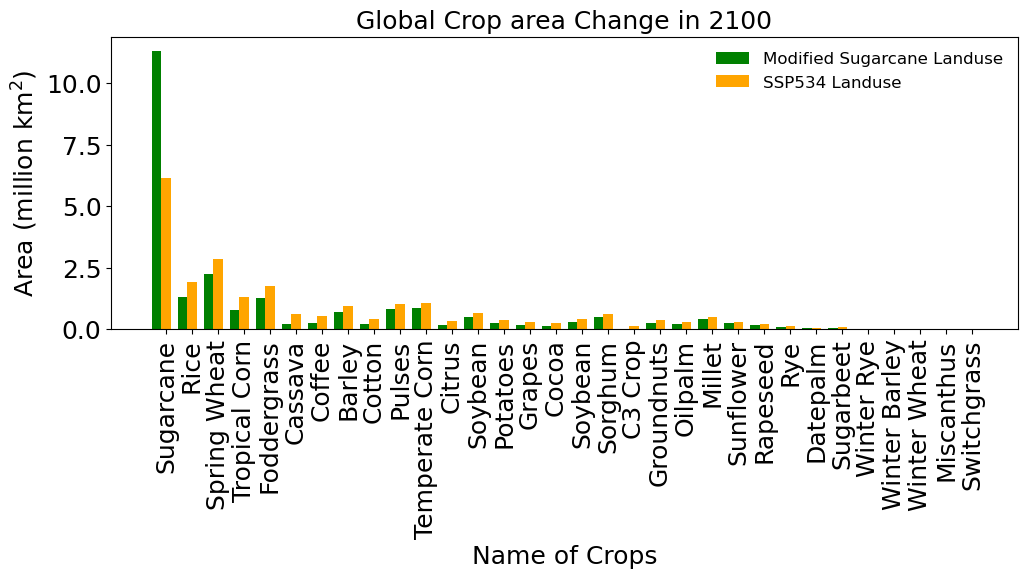

In [9]:

# Assuming your data is named 'PCT_CFT_area'
data_values = summed_sugarcane.values  # Extracting values from the xarray DataArray
datadef_values = summed_SSP534.values
absvalues=abs(data_values - datadef_values)
# Get the sorted indices based on data_values in descending order
sorted_indices = np.argsort(absvalues)[::-1]

# Sort both data arrays based on the sorted indices
sorted_data_values = data_values[sorted_indices]
sorted_datadef_values = datadef_values[sorted_indices]

# Define the number of bars and their positions
num_bars = len(data_values)
bar_width = 0.35  # Width of each bar

# Generate x-axis positions for the bars
index = np.arange(num_bars)

# Set a larger figure size to accommodate more values on the x-axis
plt.figure(figsize=(10, 5))

# Generating bar plots for the frequency/count of each category side by side
plt.bar(index, sorted_data_values/1e6, bar_width, label='Modified Sugarcane Landuse',color='green')
plt.bar(index + bar_width, sorted_datadef_values/1e6, bar_width, label='SSP534 Landuse',color='orange')

plt.xlabel('Name of Crops', fontsize=18)
plt.ylabel('Area (million km$^2$)', fontsize=18)
plt.title('Global Crop area Change in 2100', fontsize=18)
#plt.xticks(index + bar_width / 2, sorted_indices)  # Set x-ticks at the center of each group with sorted indices
plt.xticks(index + bar_width , [crop_names[i] for i in sorted_indices], rotation=90)  # Set x-ticks with crop names
plt.legend(frameon=False, fontsize='large')  # Display legend with labels
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('Globalcropareachnage2100.png', dpi=300, bbox_inches='tight')
plt.tick_params(axis='both', labelsize=18)
plt.show()

In [33]:
crop_names = [
    'C3 Crop',
    'Temperate Corn',
    'Spring Wheat',
    'Winter Wheat',
    'Soybean',
    'Barley',
    'Winter Barley',
    'Rye',
    'Winter Rye',
    'Cassava',
    'Citrus',
    'Cocoa',
    'Coffee',
    'Cotton',
    'Datepalm',
    'Foddergrass',
    'Grapes',
    'Groundnuts',
    'Millet',
    'Oilpalm',
    'Potatoes',
    'Pulses',
    'Rapeseed',
    'Rice',
    'Sorghum',
    'Sugarbeet',
    'Sugarcane',
    'Sunflower',
    'Miscanthus',
    'Switchgrass',
    'Tropical Corn',
    'Soybean']

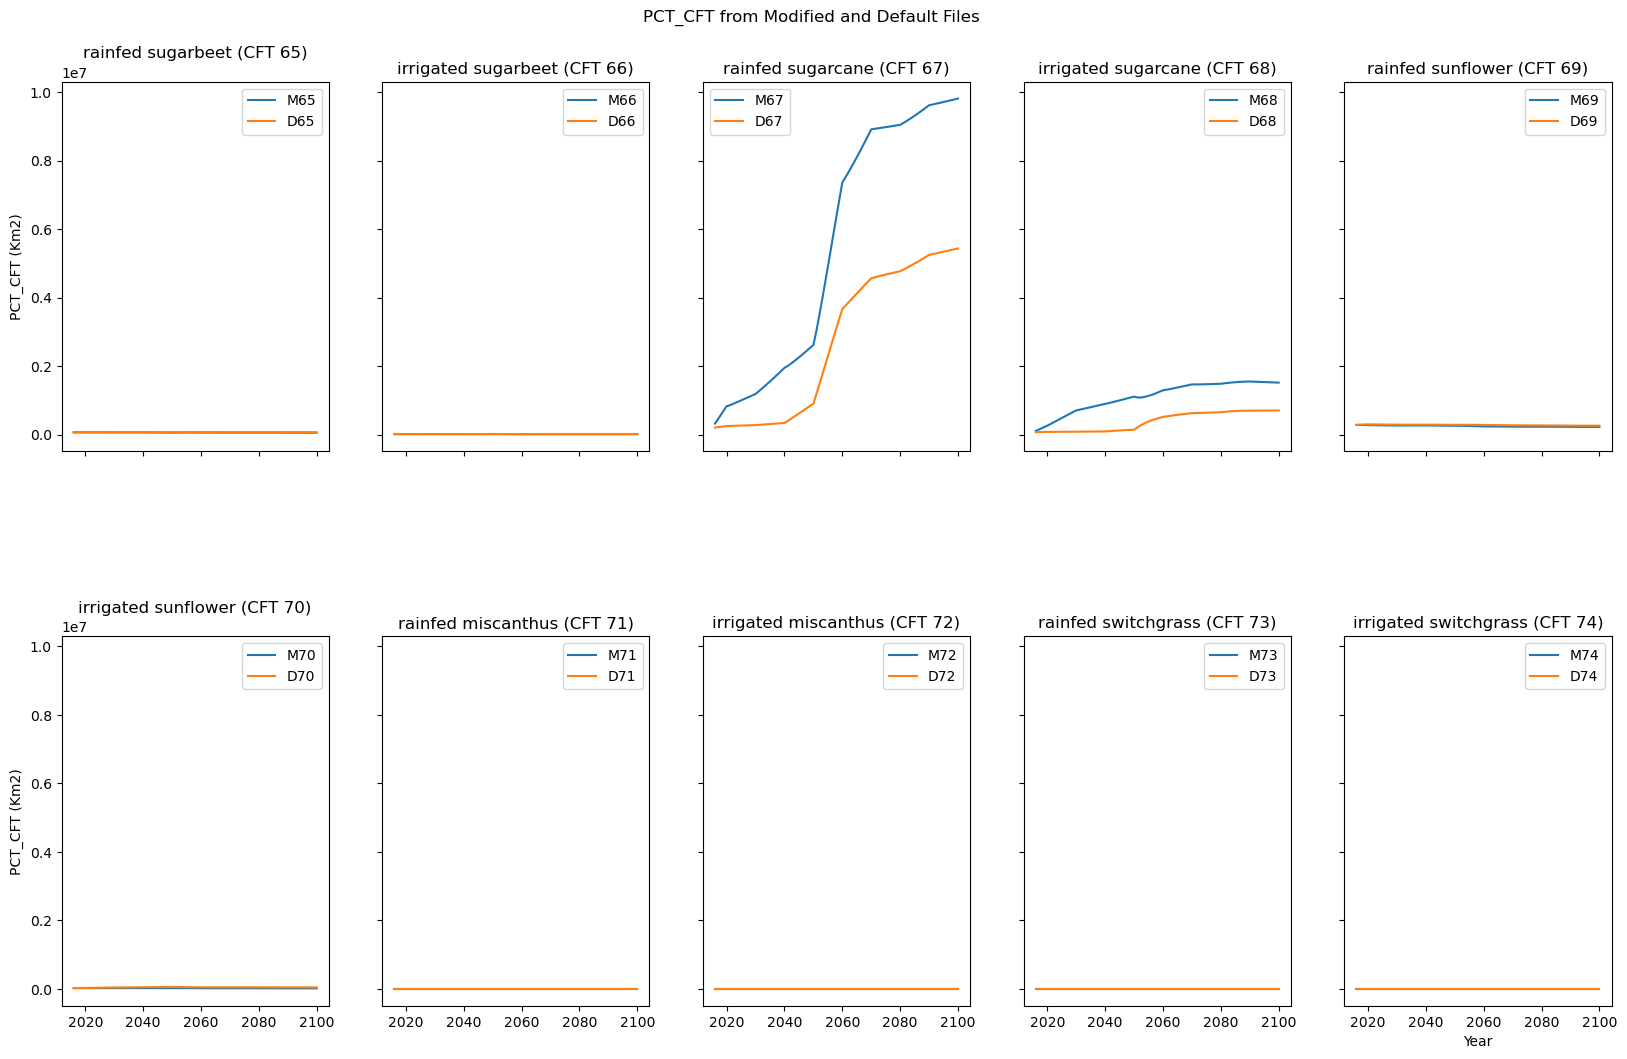

In [4]:
import matplotlib.pyplot as plt

# Define years and CFT indices
years = list(range(2016, 2101))
cft_indices = range(65, 75)

# List of CFT names
#cft_names = ['c3 unmanaged rainfed crop', 'c3 unmanaged irrigated crop', 'rainfed temperate corn', 'irrigated temperate corn', 'rainfed spring wheat', 'irrigated spring wheat', 'rainfed winter wheat', 'irrigated winter wheat', 'rainfed temperate soybean', 'irrigated temperate soybean']
#cft_names = ['rainfed barley', 'irrigated barley', 'rainfed winter barley', 'irrigated winter barley', 'rainfed rye', 'irrigated rye', 'rainfed winter rye', 'irrigated winter rye', 'rainfed cassava', 'irrigated cassava']
#cft_names = ['rainfed citrus', 'irrigated citrus', 'rainfed cocoa', 'irrigated cocoa', 'rainfed coffee', 'irrigated coffee', 'rainfed cotton', 'irrigated cotton', 'rainfed datepalm', 'irrigated datepalm']
#cft_names = ['rainfed foddergrass', 'irrigated foddergrass', 'rainfed grapes', 'irrigated grapes', 'rainfed groundnuts', 'irrigated groundnuts', 'rainfed millet', 'irrigated millet', 'rainfed oilpalm', 'irrigated oilpalm']
#cft_names = ['rainfed potatoes', 'irrigated potatoes', 'rainfed pulses', 'irrigated pulses', 'rainfed rapeseed', 'irrigated rapeseed', 'rainfed rice', 'irrigated rice', 'rainfed sorghum', 'irrigated sorghum']
cft_names = ['rainfed sugarbeet', 'irrigated sugarbeet', 'rainfed sugarcane', 'irrigated sugarcane', 'rainfed sunflower', 'irrigated sunflower', 'rainfed miscanthus', 'irrigated miscanthus', 'rainfed switchgrass', 'irrigated switchgrass']

# Create a subplot with a grid layout for CFTs
num_cfts = len(cft_indices)
num_cols = 5  # Number of columns in the grid
num_rows = 2  # Number of rows in the grid

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey=True)

# Loop through each CFT and plot in a separate panel
for i, cft in enumerate(cft_indices):
    ax = axs[i // num_cols, i % num_cols]
    ax.plot(years, cropinc_time_series.sum(['Latitude', 'Longitude']).sel(cft=cft), label=f'M{cft}')
    ax.plot(years, cropinc_def_time_series.sum(['Latitude', 'Longitude']).sel(cft=cft), label=f'D{cft}')
    ax.set_title(f'{cft_names[i]} (CFT {cft})')  # Use CFT names in subplot title
    if i == num_cfts - 1:
        ax.set_xlabel('Year')
    if i % num_cols == 0:
        ax.set_ylabel('PCT_CFT (Km2)')
    ax.legend()

# Remove empty subplots
for i in range(num_cfts, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.suptitle('PCT_CFT from Modified and Default Files', y=0.94)
plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Adjust spacing between subplots
plt.show()

In [7]:
file4 = '/cluster/shared/noresm/inputdata/mdeb/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_sugarcane_2030_c240107.nc'    #modified from Matvey for sugarcane for 2030
dset4 = xr.open_dataset(file4, decode_times=False)
dset4 = dset4.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset4=dset4.assign_coords(Latitude=dset4['LATIXY'][:,0].values)
dset4=dset4.assign_coords(Longitude=dset4['LONGXY'][0,:].values)
dset4['PCT_CFT_area'] =(dset4['PCT_CFT']/100)*dset4['AREA']*(dset4['PCT_CROP']/100)* dset4['LANDFRAC_PFT']

file5 = '/cluster/shared/noresm/inputdata/mdeb/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_sugarcane_2029_c240109.nc'    #modified from Matvey for sugarcane for 2029
dset5 = xr.open_dataset(file5, decode_times=False)
dset5 = dset5.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset5=dset5.assign_coords(Latitude=dset5['LATIXY'][:,0].values)
dset5=dset5.assign_coords(Longitude=dset5['LONGXY'][0,:].values)
dset5['PCT_CFT_area'] =(dset5['PCT_CFT']/100)*dset5['AREA']*(dset5['PCT_CROP']/100)* dset5['LANDFRAC_PFT']

file6 = '/cluster/shared/noresm/inputdata/mdeb/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_sugarcane_2025_c240110.nc'    #modified from Matvey for sugarcane for 2025
dset6 = xr.open_dataset(file6, decode_times=False)
dset6 = dset6.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset6=dset6.assign_coords(Latitude=dset6['LATIXY'][:,0].values)
dset6=dset6.assign_coords(Longitude=dset6['LONGXY'][0,:].values)
dset6['PCT_CFT_area'] =(dset6['PCT_CFT']/100)*dset6['AREA']*(dset6['PCT_CROP']/100)* dset6['LANDFRAC_PFT']

file7 = '/cluster/shared/noresm/inputdata/mdeb/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_sugarcane_2028_c240111.nc'    #modified from Matvey for sugarcane for 2028
dset7 = xr.open_dataset(file7, decode_times=False)
dset7 = dset7.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset7=dset7.assign_coords(Latitude=dset7['LATIXY'][:,0].values)
dset7=dset7.assign_coords(Longitude=dset7['LONGXY'][0,:].values)
dset7['PCT_CFT_area'] =(dset7['PCT_CFT']/100)*dset7['AREA']*(dset7['PCT_CROP']/100)* dset7['LANDFRAC_PFT']

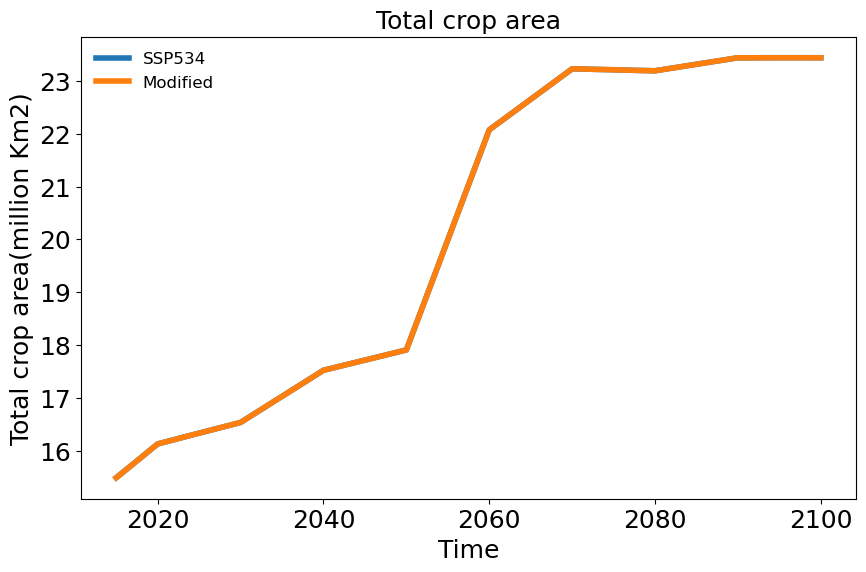

In [13]:
plt.figure(figsize=(10, 6))
(dset1['PCT_CFT_area'].sum(['cft','Latitude','Longitude']).sel(time=slice(2015,2100))/1e6).plot(label='SSP534', linewidth=4)
(dset3['PCT_CFT_area'].sum(['cft','Latitude','Longitude']).sel(time=slice(2015,2100))/1e6).plot(label='Modified', linewidth=4)
#(dset4['PCT_CFT_area'].sum(['cft','Latitude','Longitude']).sel(time=slice(2015,2100))/1e6).plot(label='Sugarcane landuse-2030criteria')
#(dset5['PCT_CFT_area'].sum(['cft','Latitude','Longitude']).sel(time=slice(2015,2100))/1e6).plot(label='Sugarcane landuse-2029criteria')
#(dset6['PCT_CFT_area'].sum(['cft','Latitude','Longitude']).sel(time=slice(2015,2100))/1e6).plot(label='Sugarcane landuse-2025criteria')
#(dset7['PCT_CFT_area'].sum(['cft','Latitude','Longitude']).sel(time=slice(2015,2100))/1e6).plot(label='Sugarcane landuse-2028criteria')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Total crop area(million Km2)', fontsize=18)
plt.title('Total crop area', fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(loc='upper left', fontsize='large', frameon=False)
plt.show()

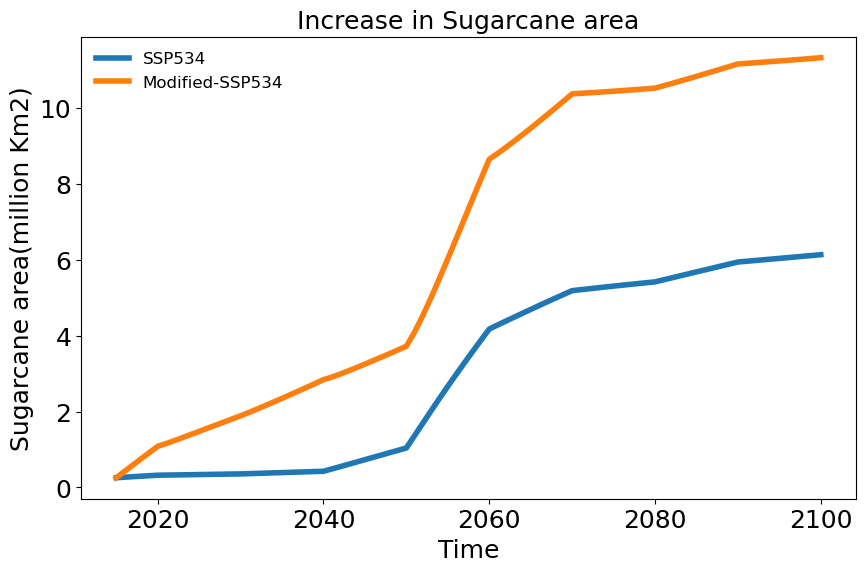

In [21]:
globsum_data1=dset1['PCT_CFT_area'].sum(['Latitude','Longitude'])
globsum_data3=dset3['PCT_CFT_area'].sum(['Latitude','Longitude'])
cane = [67,68]
globsum_data1_sugarcane=globsum_data1.sel(cft=cane).sum('cft')
globsum_data3_sugarcane=globsum_data3.sel(cft=cane).sum('cft')

plt.figure(figsize=(10, 6))
(globsum_data1_sugarcane.sel(time=slice(2015,2100))/1e6).plot(label='SSP534', linewidth=4)
(globsum_data3_sugarcane.sel(time=slice(2015,2100))/1e6).plot(label='Modified-SSP534', linewidth=4)

plt.xlabel('Time', fontsize=18)
plt.ylabel('Sugarcane area(million Km2)', fontsize=18)
plt.title('Increase in Sugarcane area', fontsize=18)
plt.legend(loc='upper left', fontsize='large', frameon=False)
plt.tick_params(axis='both', labelsize=18)

plt.savefig('Inc_Sugarcane_tseries.png', dpi=300, bbox_inches='tight')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


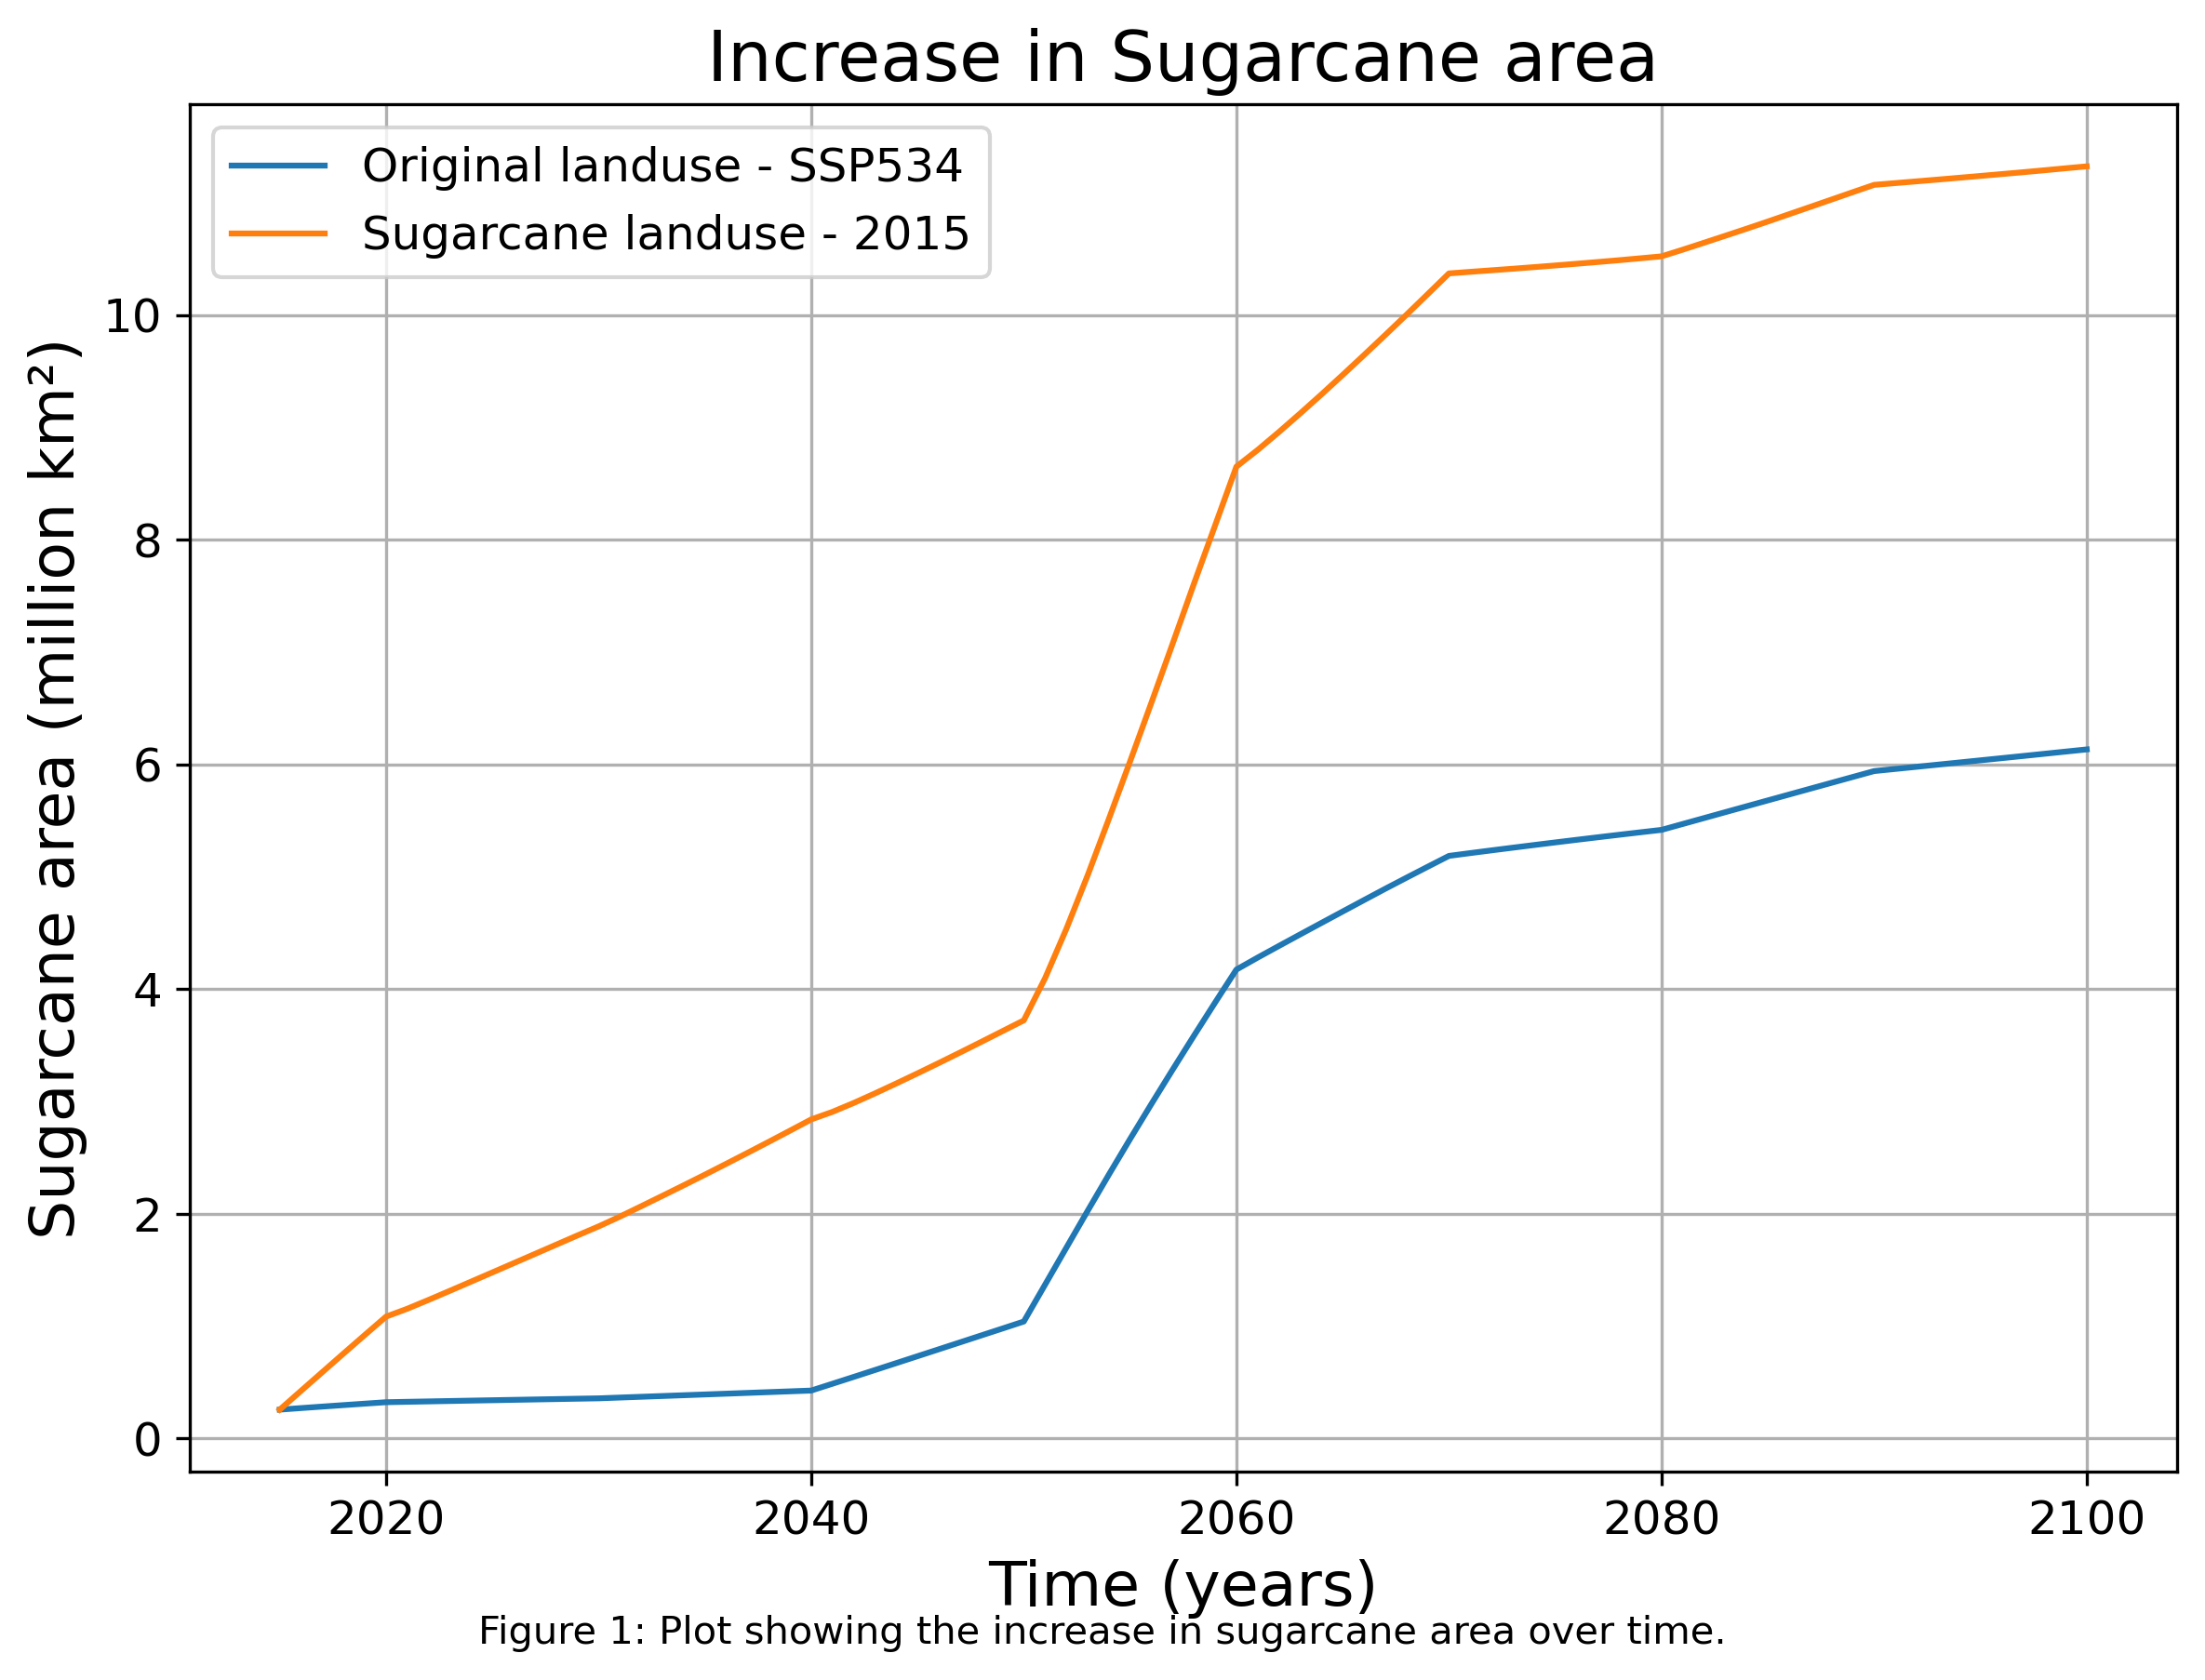

In [10]:
import matplotlib.pyplot as plt

# Define figure size and DPI
fig = plt.figure(figsize=(8, 6), dpi=300)  # Adjust size and DPI as needed

# Plotting data
(globsum_data1_sugarcane.sel(time=slice(2015, 2100))/1e6).plot(label='Original landuse - SSP534')
(globsum_data3_sugarcane.sel(time=slice(2015, 2100))/1e6).plot(label='Sugarcane landuse - 2015')

# Axis labels with larger font size
plt.xlabel('Time (years)', fontsize=16, fontname='Arial')
plt.ylabel('Sugarcane area (million km²)', fontsize=16, fontname='Arial')

# Title with larger font size
plt.title('Increase in Sugarcane area', fontsize=18, fontname='Arial')

# Legend with larger font size
plt.legend(fontsize=12)

# Increase font size for x-axis and y-axis tick labels
plt.tick_params(axis='both', which='major', labelsize=12)

# Add gridlines
plt.grid(True)

# Add caption
plt.figtext(0.5, 0.01, 'Figure 1: Plot showing the increase in sugarcane area over time.', wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
#plt.show()


## write to a csv file, the total sugarcane area

In [15]:
# Assuming globsum_data1_sugarcane, globsum_data3_sugarcane, etc., are DataArrays or DataFrames.

# Assuming you have a common time coordinate for all datasets
time_coords = globsum_data1_sugarcane.sel(time=slice(2015, 2100))['time']

# Create a DataFrame with the required columns
df = pd.DataFrame({
    'Time': time_coords.values,
    'Totalcroparea_SSP534' : Totalcroparea.sel(time=slice(2015,2100)).values/1e6,
    'Original_landuse_SSP534': globsum_data1_sugarcane.sel(time=slice(2015, 2100)).values / 1e6,
    'Sugarcane_landuse_2015': globsum_data3_sugarcane.sel(time=slice(2015, 2100)).values / 1e6,
    'Sugarcane_landuse_2030': globsum_data4_sugarcane.sel(time=slice(2015, 2100)).values / 1e6,
    #'Sugarcane_landuse_2029': globsum_data5_sugarcane.sel(time=slice(2015, 2100)).values / 1e6,
    'Sugarcane_landuse_2025': globsum_data6_sugarcane.sel(time=slice(2015, 2100)).values / 1e6,
})

# Write the DataFrame to a space-separated .dat file
df.to_csv('/cluster/projects/nn9576k/anusha/output/Croparea_sugarcane_2015-2100.txt', sep=',', index=False)


##find  the crop area increase wrt 2015 and 2030 in the new landuse file

In [13]:
years = range(2016, 2101)  # Including 2100

# Initialize an empty list to store the Cropinc values
cropinc_values = []
cropinc_def_values = []
cropinc_2030_values = []
# Assuming 'cane_mod_sum' is an xarray DataArray with a 'time' dimension
# Define the base year (2015)
base_year = 2015
# Calculate Cropinc for each year
for year in years:
    # Calculate the difference between 'cane_mod_sum' for the current year and the base year
    cropinc = (dset3['PCT_CFT_area'].sel(time=year)) #- (dset3['PCT_CFT_area'].sel(time=base_year))
    cropinc_def = (dset1['PCT_CFT_area'].sel(time=year))# - (dset1['PCT_CFT_area'].sel(time=base_year))
    cropinc_2030 = (dset4['PCT_CFT_area'].sel(time=year))
    # Append the result to the list
    cropinc_values.append(cropinc)
    cropinc_def_values.append(cropinc_def)
    cropinc_2030_values.append(cropinc_2030)
cropinc_time_series = xr.concat(cropinc_values, dim='time')
cropinc_def_time_series = xr.concat(cropinc_def_values, dim='time')
cropinc_2030_time_series = xr.concat(cropinc_2030_values, dim='time')
#cropinc_time_series.sum(['Latitude','Longitude']).sel(cft=15).plot

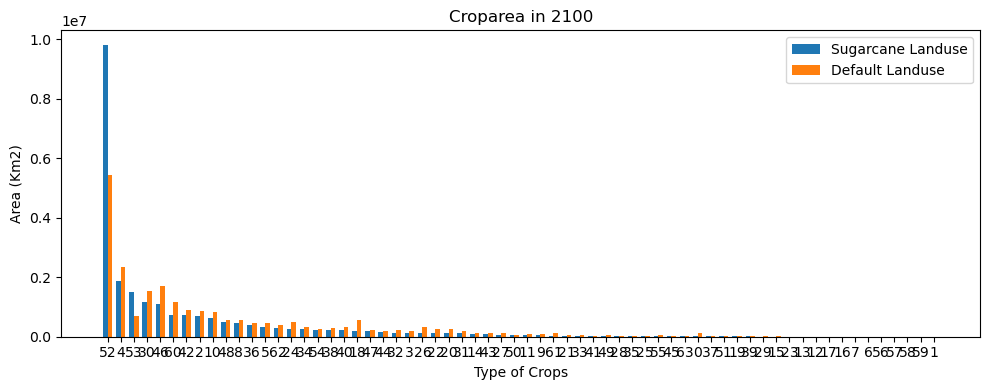

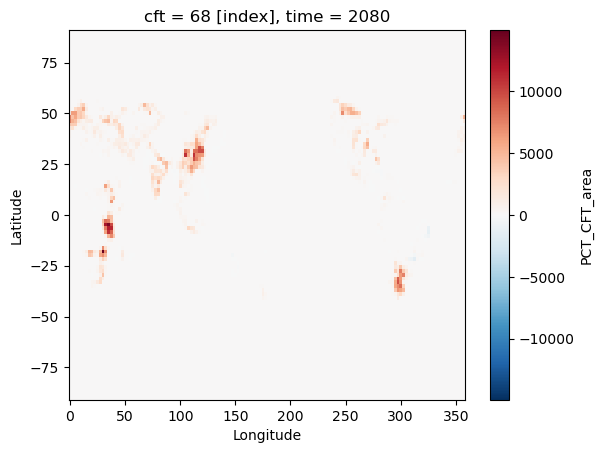

In [7]:
years = list(range(2016, 2101))
cropinc_time_series['time'] = years
cropinc_time_series.sel(time=2080).sel(cft=68).plot()

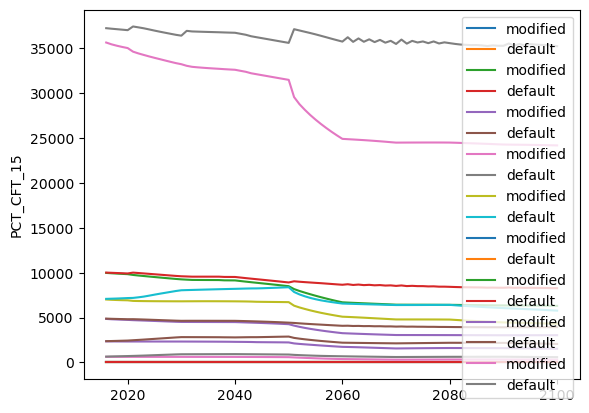

In [3]:
years = list(range(2016, 2101))
cft_indices = range(16,25)
for cft in cft_indices:  
    #plt.plot(years, cropinc_time_series.sum(['Latitude','Longitude']).sel(cft=cft))
    plt.plot(years, dset3['PCT_CFT'].sum(['Latitude','Longitude']).sel(cft=cft).sel(time=slice(2016, 2101)),label='modified')
    plt.plot(years, dset1['PCT_CFT'].sum(['Latitude','Longitude']).sel(cft=cft).sel(time=slice(2016, 2101)),label='default')
    plt.legend()
    plt.ylabel('PCT_CFT_15')

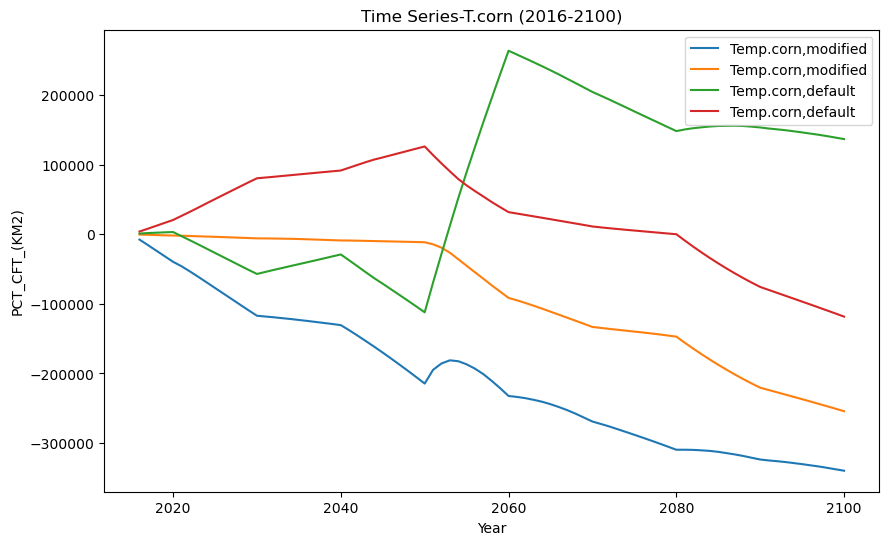

In [8]:
cane = [19,20]
plt.figure(figsize=(10, 6))
plt.plot(years, cropinc_time_series.sum(['Latitude','Longitude']).sel(cft=cane),label='Temp.corn,modified')
plt.plot(years, cropinc_def_time_series.sum(['Latitude','Longitude']).sel(cft=cane),label='Temp.corn,default')

plt.title('Time Series-T.corn (2016-2100)')
plt.xlabel('Year')
plt.ylabel('PCT_CFT_(KM2)')
plt.legend()
plt.show()


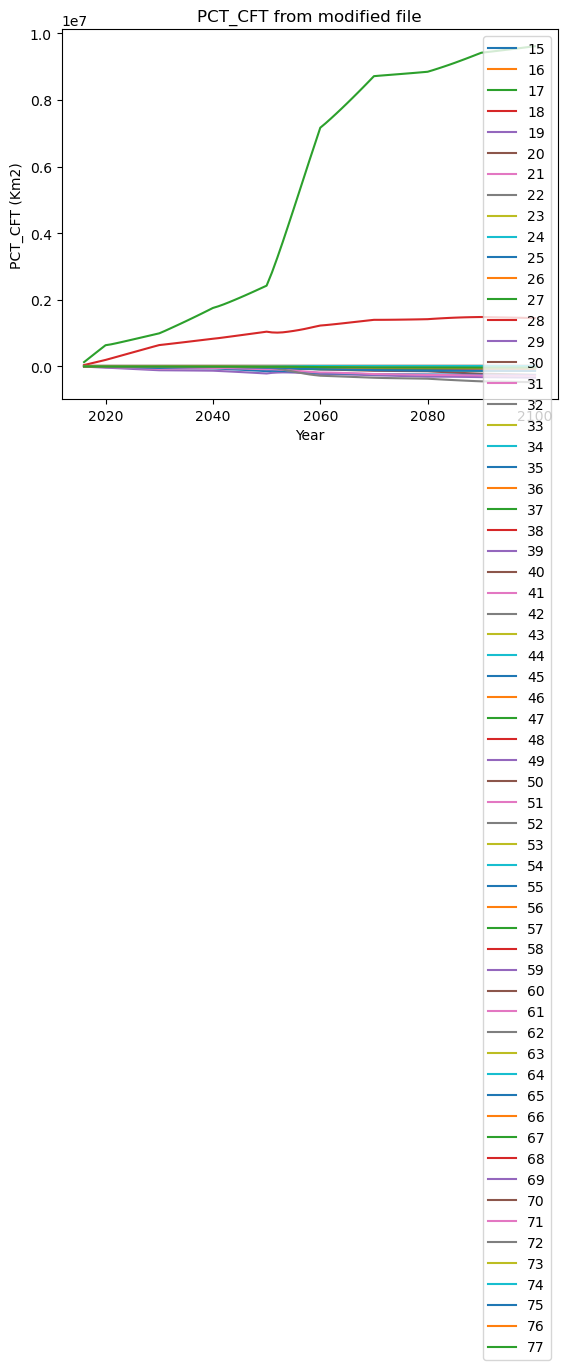

In [9]:
years = list(range(2016, 2101))
cft_indices = range(15,78)
for cft in cft_indices:  
    plt.plot(years, cropinc_time_series.sum(['Latitude','Longitude']).sel(cft=cft),label=cft)
    #plt.plot(years, cropinc_def_time_series.sum(['Latitude','Longitude']).sel(cft=cft))
    #plt.plot(years, dset3['PCT_CFT'].sum(['Latitude','Longitude']).sel(cft=cft).sel(time=slice(2016, 2101)),label='modified')
    #plt.plot(years, dset1['PCT_CFT'].sum(['Latitude','Longitude']).sel(cft=cft).sel(time=slice(2016, 2101)),label='default')
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('PCT_CFT (Km2)')
    plt.title('PCT_CFT from modified file')

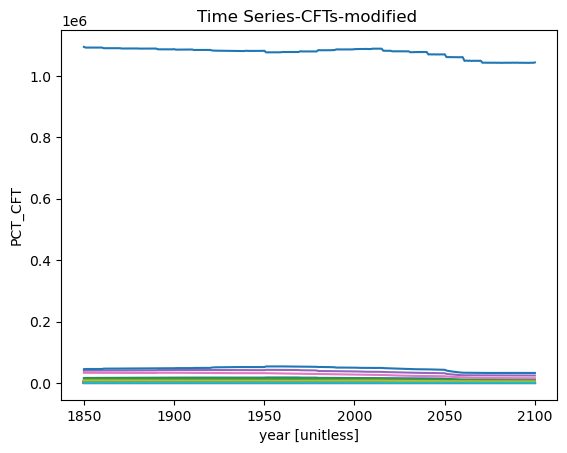

In [133]:
#base_year= dset3['PCT_CFT'].sel(cft=15).sel(time=2015)

cft_indices = range(15, 65)
for cft in cft_indices:  
    dset3['PCT_CFT'].sel(cft=cft).sum(['Latitude','Longitude']).plot()
    plt.title('Time Series-CFTs-modified ')


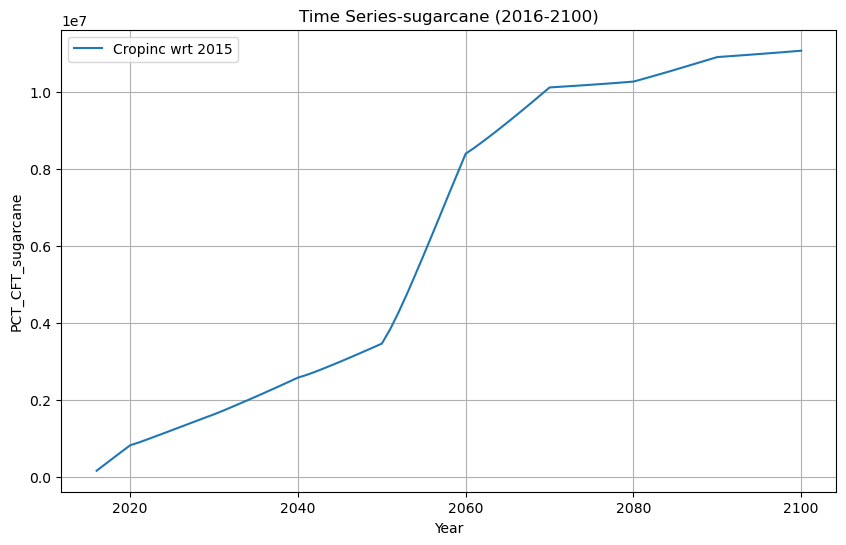

array([  166997.45855288,   333217.82072642,   499442.81610667,
         664383.00977608,   827971.78669956,   898060.29627721,
         976790.39602861,  1057562.99187367,  1139320.29727416,
        1221211.15686823,  1303380.12823667,  1385642.55260039,
        1467957.85750343,  1550318.16171265,  1631145.77291377,
        1718213.58597191,  1810348.7740896 ,  1903267.66717096,
        1996848.77022495,  2091755.40590468,  2188201.28716834,
        2285432.78534775,  2383761.34663412,  2483230.02187358,
        2583607.80283982,  2650954.1133899 ,  2730151.53353811,
        2815327.79134706,  2903488.34901587,  2993640.74992152,
        3085554.61062168,  3179092.64009257,  3273924.93636944,
        3369644.14203995,  3465548.33831326,  3840581.98629221,
        4279147.77007037,  4754831.22823244,  5258334.35720063,
        5771227.4482697 ,  6292358.56086953,  6818855.78936364,
        7350945.93305668,  7872765.01651152,  8395016.99640643,
        8543654.99295547,  8703232.39411

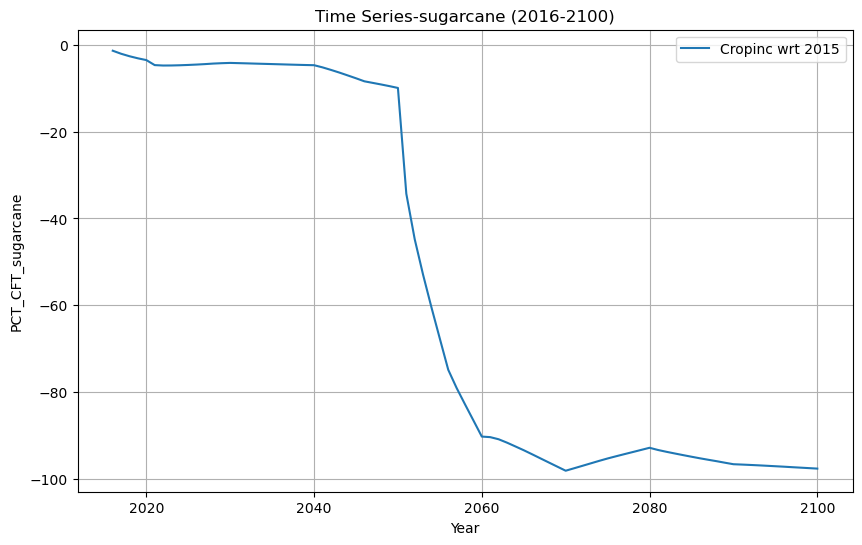

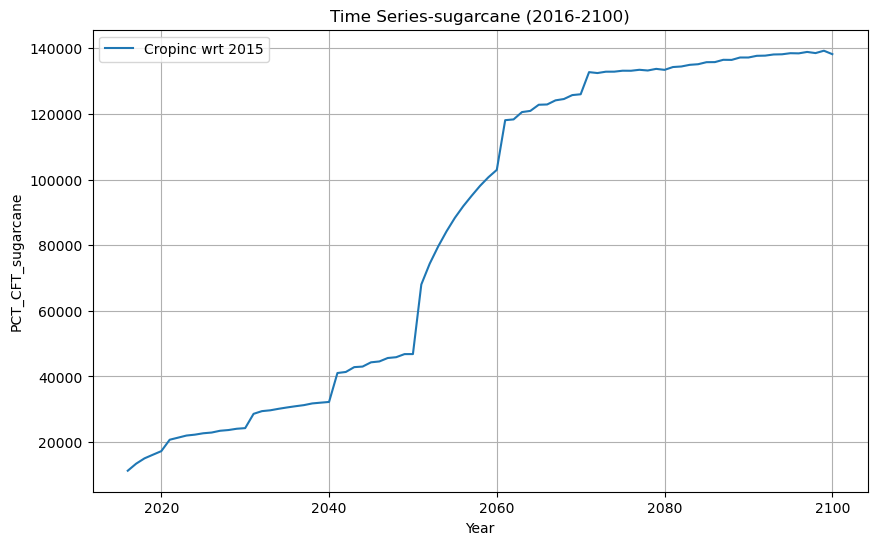

In [18]:
cft_indices = range(66, 68)
for cft in cft_indices:
    cane_mod=dset3['PCT_CFT'].sel(cft=cft)
    cane_mod_sum=cane_mod.sum(['Latitude','Longitude'])
    years = range(2016, 2101) 
    cropinc_values = []
    base_year = 2015
    for year in years:
        cropinc = cane_mod_sum.sel(time=year) - cane_mod_sum.sel(time=base_year)
        cropinc_values.append(cropinc)
    
    cropinc_time_series = xr.concat(cropinc_values, dim='time')
    cropinc_values = cropinc_time_series.values

    plt.figure(figsize=(10, 6))
    plt.plot(years, cropinc_values, label='Cropinc wrt 2015')
    plt.title('Time Series-sugarcane (2016-2100)')
    plt.xlabel('Year')
    plt.ylabel('PCT_CFT_sugarcane')
    plt.grid(True)
    plt.legend()
    plt.show()
    

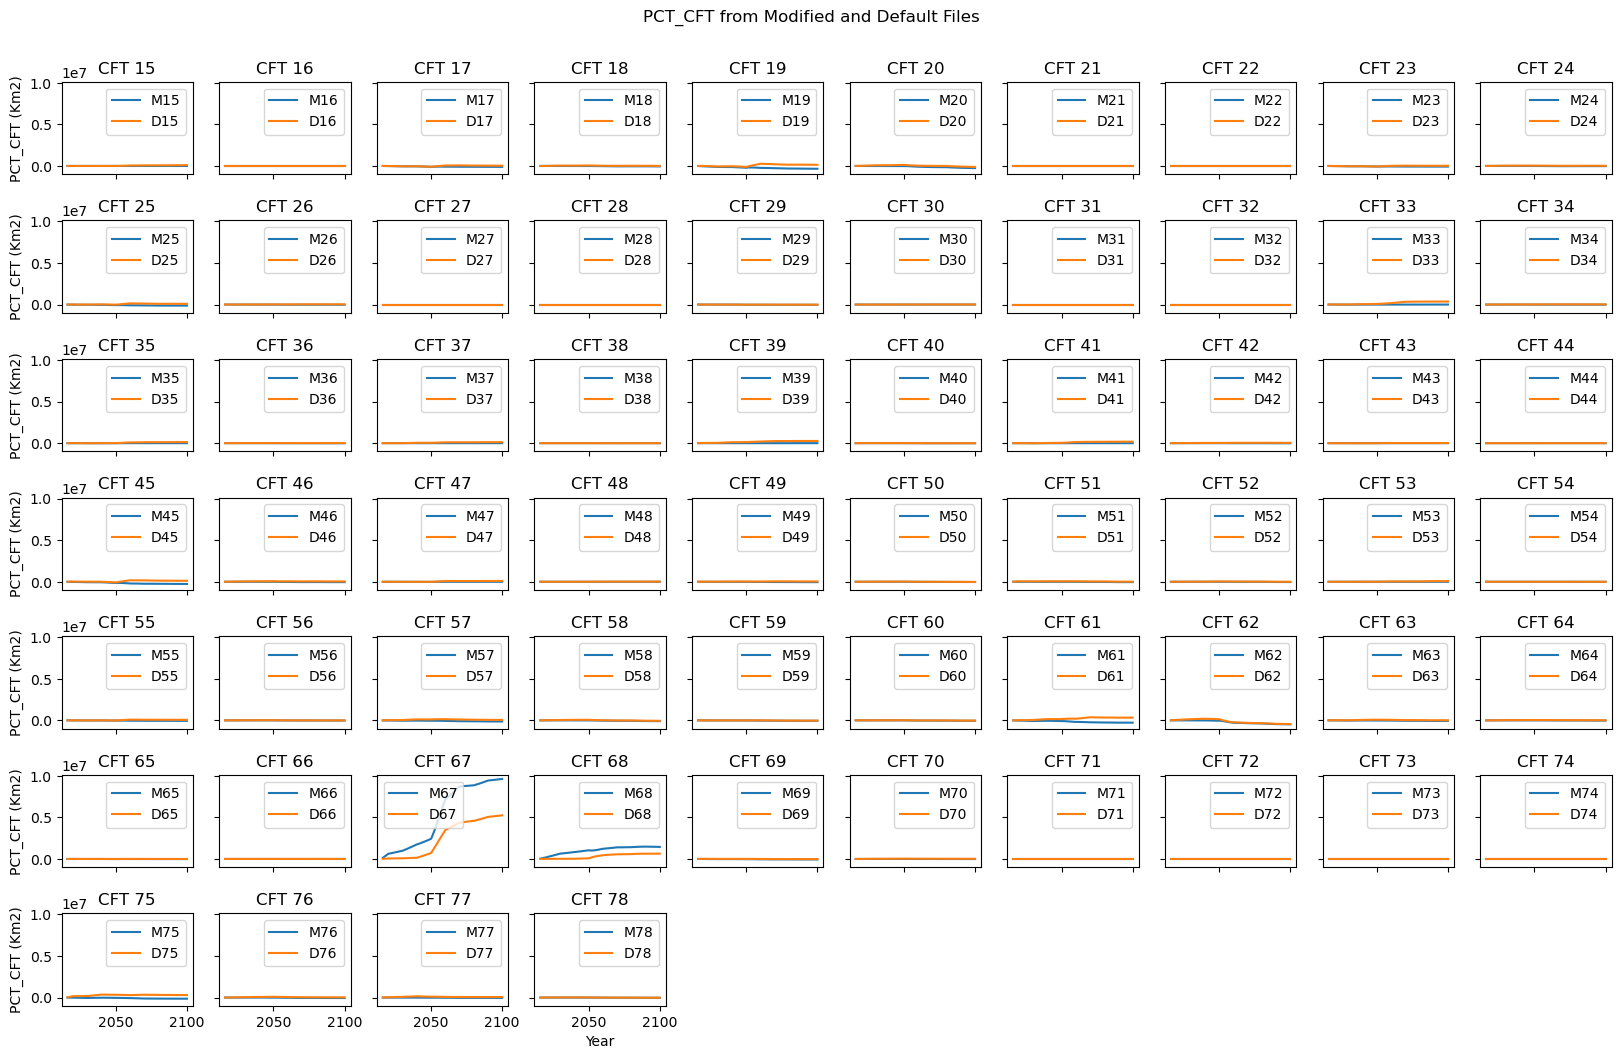

In [39]:
import matplotlib.pyplot as plt

# Define years and CFT indices
years = list(range(2016, 2101))
cft_indices = range(15, 79)

# Create a subplot with a grid layout for CFTs
num_cfts = len(cft_indices)
num_cols = 10  # Number of columns in the grid
num_rows = (num_cfts - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey=True)

# Loop through each CFT and plot in a separate panel
for i, cft in enumerate(cft_indices):
    ax = axs[i // num_cols, i % num_cols]
    ax.plot(years, cropinc_time_series.sum(['Latitude', 'Longitude']).sel(cft=cft), label=f'M{cft}')
    ax.plot(years, cropinc_def_time_series.sum(['Latitude', 'Longitude']).sel(cft=cft), label=f'D{cft}')
    ax.set_title(f'CFT {cft}')
    if i == num_cfts - 1:
        ax.set_xlabel('Year')
    if i % num_cols == 0:
        ax.set_ylabel('PCT_CFT (Km2)')
    ax.legend()
    #ax.set_ylim(0e7, 0.6e7)

# Remove empty subplots
for i in range(num_cfts, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.suptitle('PCT_CFT from Modified and Default Files', y=0.94)
plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Adjust spacing between subplots
plt.show()



NameError: name 'cropinc_time_series' is not defined

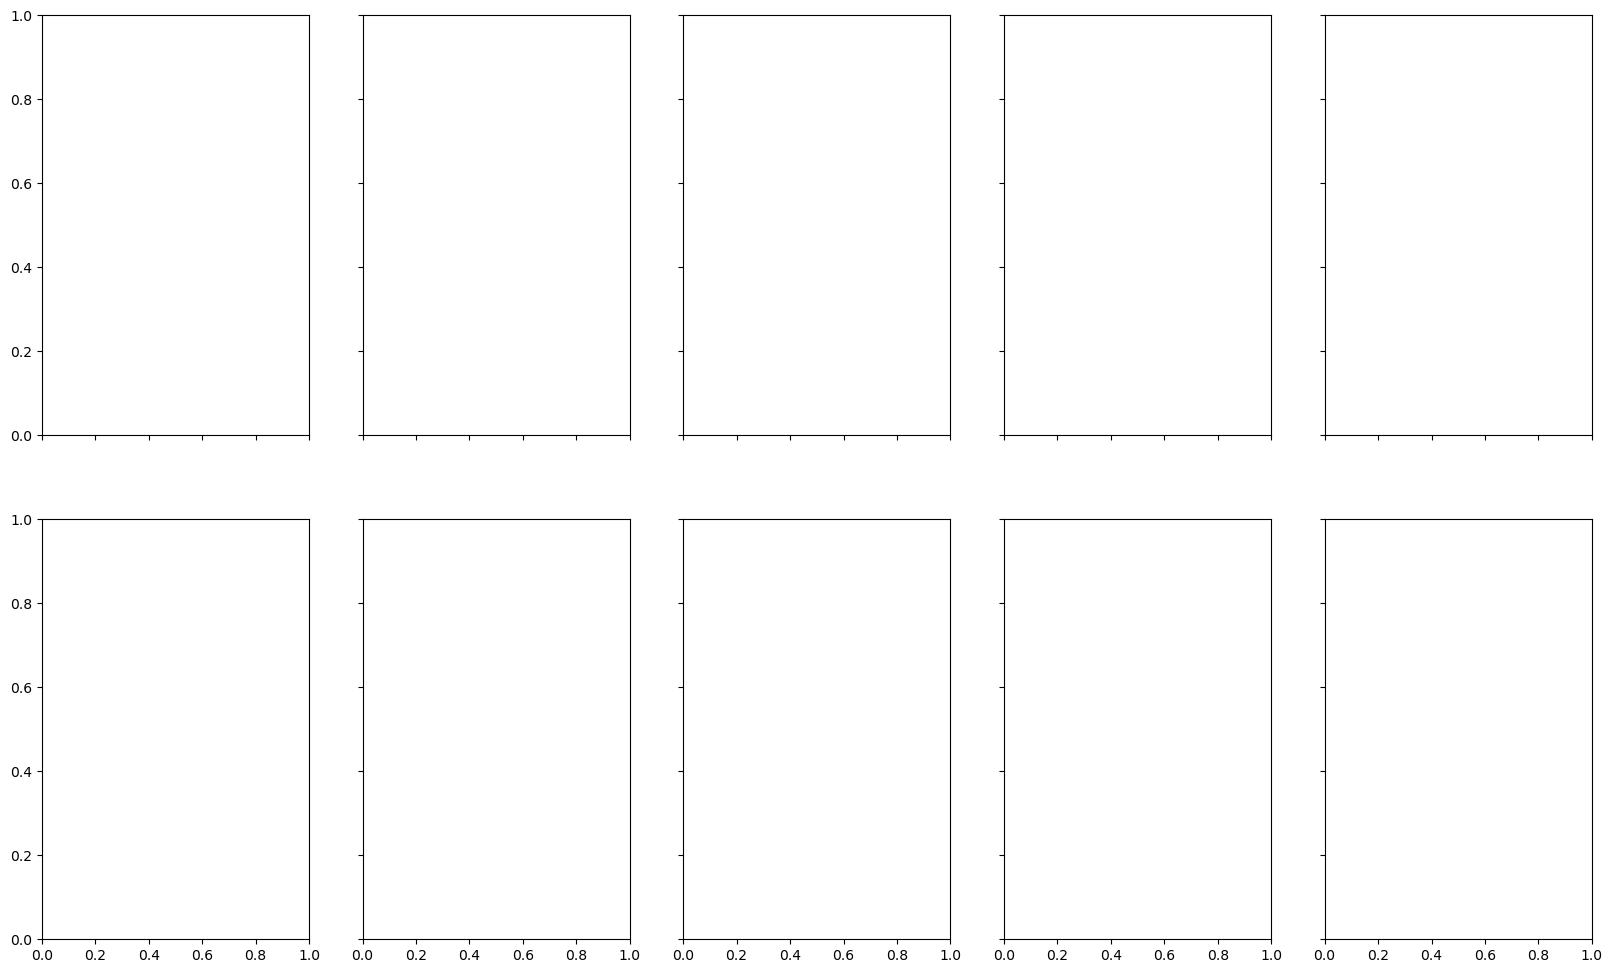

In [4]:
import matplotlib.pyplot as plt

# Define years and CFT indices
years = list(range(2016, 2101))
cft_indices = range(65, 75)

# List of CFT names
#cft_names = ['c3 unmanaged rainfed crop', 'c3 unmanaged irrigated crop', 'rainfed temperate corn', 'irrigated temperate corn', 'rainfed spring wheat', 'irrigated spring wheat', 'rainfed winter wheat', 'irrigated winter wheat', 'rainfed temperate soybean', 'irrigated temperate soybean']
#cft_names = ['rainfed barley', 'irrigated barley', 'rainfed winter barley', 'irrigated winter barley', 'rainfed rye', 'irrigated rye', 'rainfed winter rye', 'irrigated winter rye', 'rainfed cassava', 'irrigated cassava']
#cft_names = ['rainfed citrus', 'irrigated citrus', 'rainfed cocoa', 'irrigated cocoa', 'rainfed coffee', 'irrigated coffee', 'rainfed cotton', 'irrigated cotton', 'rainfed datepalm', 'irrigated datepalm']
#cft_names = ['rainfed foddergrass', 'irrigated foddergrass', 'rainfed grapes', 'irrigated grapes', 'rainfed groundnuts', 'irrigated groundnuts', 'rainfed millet', 'irrigated millet', 'rainfed oilpalm', 'irrigated oilpalm']
#cft_names = ['rainfed potatoes', 'irrigated potatoes', 'rainfed pulses', 'irrigated pulses', 'rainfed rapeseed', 'irrigated rapeseed', 'rainfed rice', 'irrigated rice', 'rainfed sorghum', 'irrigated sorghum']
cft_names = ['rainfed sugarbeet', 'irrigated sugarbeet', 'rainfed sugarcane', 'irrigated sugarcane', 'rainfed sunflower', 'irrigated sunflower', 'rainfed miscanthus', 'irrigated miscanthus', 'rainfed switchgrass', 'irrigated switchgrass']

# Create a subplot with a grid layout for CFTs
num_cfts = len(cft_indices)
num_cols = 5  # Number of columns in the grid
num_rows = 2  # Number of rows in the grid

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey=True)

# Loop through each CFT and plot in a separate panel
for i, cft in enumerate(cft_indices):
    ax = axs[i // num_cols, i % num_cols]
    ax.plot(years, cropinc_time_series.sum(['Latitude', 'Longitude']).sel(cft=cft), label=f'M{cft}')
    ax.plot(years, cropinc_def_time_series.sum(['Latitude', 'Longitude']).sel(cft=cft), label=f'D{cft}')
    ax.set_title(f'{cft_names[i]} (CFT {cft})')  # Use CFT names in subplot title
    if i == num_cfts - 1:
        ax.set_xlabel('Year')
    if i % num_cols == 0:
        ax.set_ylabel('PCT_CFT (Km2)')
    ax.legend()

# Remove empty subplots
for i in range(num_cfts, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.suptitle('PCT_CFT from Modified and Default Files', y=0.94)
plt.subplots_adjust(wspace=0.2, hspace=0.5)  # Adjust spacing between subplots
plt.show()

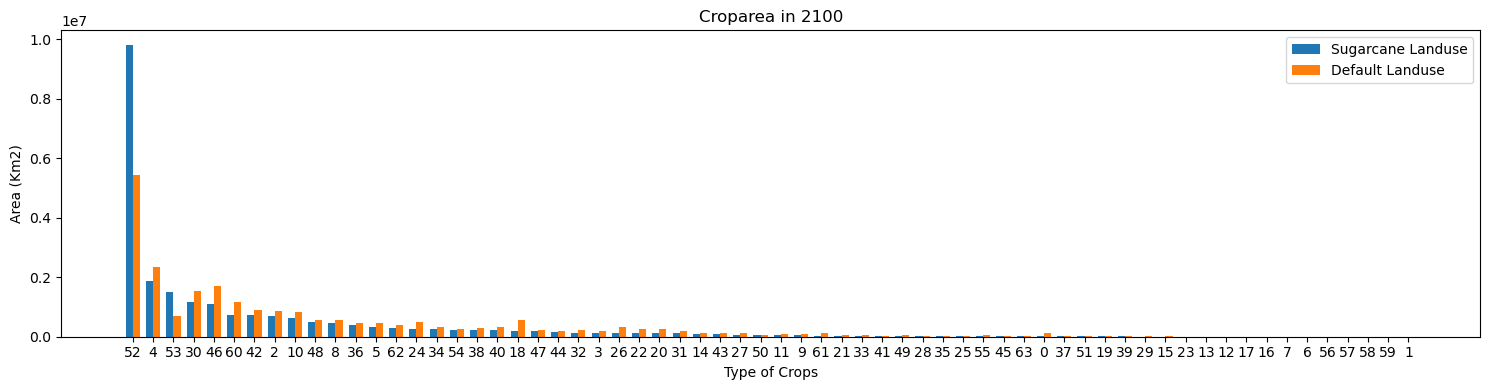

In [5]:
import matplotlib.pyplot as plt

data_values = Cropareaincrease_2100  # Replace with your actual data values
datadef_values = Cropareadefault_2100  # Replace with your actual data values

# Generating a bar plot for the frequency/count of each category
plt.bar(range(len(data_values)), data_values, label='Increase')
plt.bar(range(len(datadef_values)), datadef_values, label='Default')

plt.xlabel('Categories')
plt.ylabel('Frequency/Count')
plt.title('Bar plot of PCT_CFT_area categories')
plt.legend()  # Display legend with labels
plt.show()


NameError: name 'Cropareaincrease_2100' is not defined

In [6]:
cft_indices = range(15, 65)

cane_mod=dset3['PCT_CFT'].sel(cft=cane).sum('cft')
cane_mod_sum=cane_mod.sum(['Latitude','Longitude'])

years = range(2016, 2101)  # Including 2100


cropinc_values = []

base_year = 2015

for year in years:

    cropinc = cane_mod_sum.sel(time=year) - cane_mod_sum.sel(time=base_year)

    cropinc_values.append(cropinc)
cropinc_time_series = xr.concat(cropinc_values, dim='time')
years = list(range(2016, 2101))
cropinc_values = cropinc_time_series.values

NameError: name 'cane' is not defined

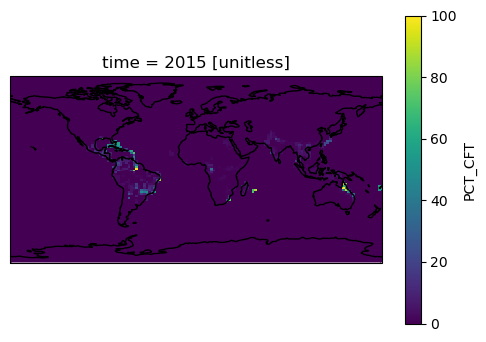

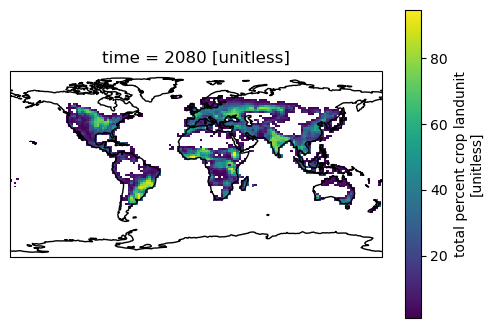

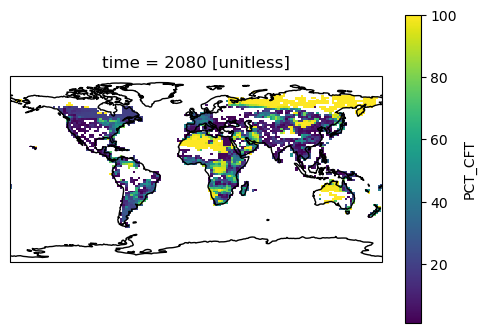

In [3]:
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
cane_def=dset1['PCT_CFT'].sel(cft=cane).sum('cft')
#(cane_def/100).to_netcdf('/cluster/projects/nn9576k/anusha/DATA/cane_default_frac.nc')
#dset1['PCT_CROP'].sel(time=2080).where(dset1['PCT_CROP'].sel(time=2080) > 1).
cane_def.sel(time=2015).plot()
axs.coastlines(linewidth=1)
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
cane_mod=dset3['PCT_CFT'].sel(cft=cane).sum('cft')
#(cane_mod/100).to_netcdf('/cluster/projects/nn9576k/anusha/DATA/cane_modified_frac.nc')
(dset3['PCT_CROP'].sel(time=2080).where(dset3['PCT_CROP'].sel(time=2080) > 1)).plot()
axs.coastlines(linewidth=1)
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
#((cane_mod-cane_def)/100).to_netcdf('/cluster/projects/nn9576k/anusha/DATA/cane_modified-def_frac.nc')
((cane_mod-cane_def)).sel(time=2080).where((cane_mod-cane_def).sel(time=2080) > 1).plot()
axs.coastlines(linewidth=1)
#((cane_mod/cane_def)/100).to_netcdf('/cluster/projects/nn9576k/anusha/DATA/cane_modified_to_def_ratio_frac.nc')

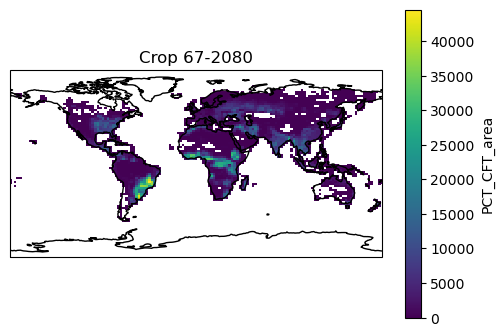

In [11]:
crop = range(67, 68)
for crop in crop:
    fig, axs = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    cane_def = dset3['PCT_CFT_area'].sel(cft=crop)
    cane_def.sel(time=2080).where(cane_def.sel(time=2080)>0).plot()
    axs.coastlines(linewidth=1)
    axs.set_title(f'Crop {crop}-2080', fontsize=12)
    plt.show()

##Conmpare the modified landuse file and original

In [47]:
file1 = '/cluster/shared/noresm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_CMIP6_simyr1850-2100_c190228.nc'     #SSP534
#file1 = '/cluster/projects/nn9576k/anusha/DATA/landuse.timeseries_1.9x2.5_SSP4-3.4_78pfts_CMIP6_simyr1850-2100_c190228.nc'  #SSP434
dset1 = xr.open_dataset(file1, decode_times=False)
dset1 = dset1.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset1=dset1.assign_coords(Latitude=dset1['LATIXY'][:,0].values)
dset1=dset1.assign_coords(Longitude=dset1['LONGXY'][0,:].values)

file2 = '/cluster/shared/noresm/inputdata/mdeb/landuse.timeseries_1.9x2.5_SSP5-3.4_all_corn.nc'     #modified from Matvey for corn
dset2 = xr.open_dataset(file2, decode_times=False)
dset2 = dset2.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset2=dset2.assign_coords(Latitude=dset2['LATIXY'][:,0].values)
dset2=dset2.assign_coords(Longitude=dset2['LONGXY'][0,:].values)

file3 = '/cluster/shared/noresm/inputdata/mdeb/landuse.timeseries_1.9x2.5_SSP5-3.4_78pfts_sugarcane.nc'     #modified from Matvey for sugarcane
dset3 = xr.open_dataset(file3, decode_times=False)
dset3 = dset3.rename_dims({'lsmlat': 'Latitude', 'lsmlon': 'Longitude'})
dset3=dset3.assign_coords(Latitude=dset3['LATIXY'][:,0].values)
dset3=dset3.assign_coords(Longitude=dset3['LONGXY'][0,:].values)


[15]

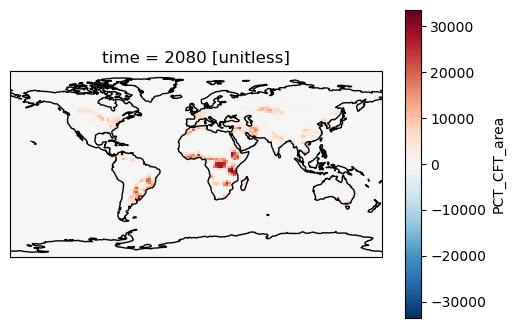

In [52]:
cane = [67,68]
dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['AREA']*(dset1['PCT_CROP']/100)* dset1['LANDFRAC_PFT']
dset2['PCT_CFT_area'] =(dset2['PCT_CFT']/100)*dset2['AREA']*(dset2['PCT_CROP']/100)* dset2['LANDFRAC_PFT']
dset3['PCT_CFT_area'] =(dset3['PCT_CFT']/100)*dset3['AREA']*(dset3['PCT_CROP']/100)* dset3['LANDFRAC_PFT']
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
diff=(dset3['PCT_CFT_area'])-(dset1['PCT_CFT_area'])
diff.sel(cft=cane).sum('cft').sel(time=2080).plot()
axs.coastlines(linewidth=1)
diff.to_netcdf('/cluster/projects/nn9576k/anusha/DATA/additionalarea_cane_km2.nc')

In [53]:
diff.sel(cft=cane).sum('cft').sel(time=2080).sum()

<xarray.DataArray 'PCT_CFT_area' ()>
array(5106042.15604188)
Coordinates:
    time     int32 2080

In [16]:
dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['AREA']*(dset1['PCT_CROP']/100)* dset1['LANDFRAC_PFT']
dset2['PCT_CFT_area'] =(dset2['PCT_CFT']/100)*dset2['AREA']*(dset2['PCT_CROP']/100)* dset2['LANDFRAC_PFT']
dset3['PCT_CFT_area'] =(dset3['PCT_CFT']/100)*dset3['AREA']*(dset3['PCT_CROP']/100)* dset3['LANDFRAC_PFT']

corn = [17,18,75,76]
cane = [67,68]

## from default simulation -2015
Totarea_2015_def=(dset1['PCT_CFT_area'].sum('cft').sel(time=2015))/1e6
sugarcane_area_2015  =(dset1['PCT_CFT_area'].sel(cft=cane).sum('cft').sel(time=2015))/1e6 #natpft=slice(12,14)
corn_area_2015  =(dset1['PCT_CFT_area'].sel(cft=corn).sum('cft').sel(time=2015))/1e6

area_2015_def = Totarea_2015_def.where(Totarea_2015_def != 0)
area_2015_cane = sugarcane_area_2015.where(sugarcane_area_2015 != 0)
area_2015_corn = corn_area_2015.where(corn_area_2015 != 0)

## from default simulation-2080
Totarea_2080_def=(dset1['PCT_CFT_area'].sum('cft').sel(time=2080))/1e6
sugarcane_area  =(dset1['PCT_CFT_area'].sel(cft=cane).sum('cft').sel(time=2080))/1e6 #natpft=slice(12,14)
corn_area  =(dset1['PCT_CFT_area'].sel(cft=corn).sum('cft').sel(time=2080))/1e6

area_2080_def = Totarea_2080_def.where(Totarea_2080_def != 0)
area_2080_cane = sugarcane_area.where(sugarcane_area != 0)
area_2080_corn = corn_area.where(corn_area != 0)

#from modified landuse simulation-corn
Totarea_corncase_2080=(dset2['PCT_CFT_area'].sum('cft').sel(time=2080))/1e6
sugarcanearea_corncase_2080  =(dset2['PCT_CFT_area'].sel(cft=cane).sum('cft').sel(time=2080))/1e6 #natpft=slice(12,14)
corn_area_corncase_2080  =(dset2['PCT_CFT_area'].sel(cft=corn).sum('cft').sel(time=2080))/1e6
area_2080_tot_corncase = Totarea_corncase_2080.where(Totarea_corncase_2080 != 0)
area_2080_cane_corncase = sugarcanearea_corncase_2080.where(sugarcanearea_corncase_2080 != 0)
area_2080_corn_corncase = corn_area_corncase_2080.where(corn_area_corncase_2080 != 0)


#from modified landuse simulation-sugarcane
Totarea_2080_canecase=(dset3['PCT_CFT_area'].sum('cft').sel(time=2080))/1e6
sugarcane_area_canecase  =(dset3['PCT_CFT_area'].sel(cft=cane).sum('cft').sel(time=2080))/1e6 #natpft=slice(12,14)
corn_area_canecase  =(dset3['PCT_CFT_area'].sel(cft=corn).sum('cft').sel(time=2080))/1e6
area_2080_tot_canecase = Totarea_2080_canecase.where(Totarea_2080_canecase != 0)
area_2080_cane_canecase = sugarcane_area_canecase.where(sugarcane_area_canecase != 0)
area_2080_corn_canecase = corn_area_canecase.where(corn_area_canecase != 0)

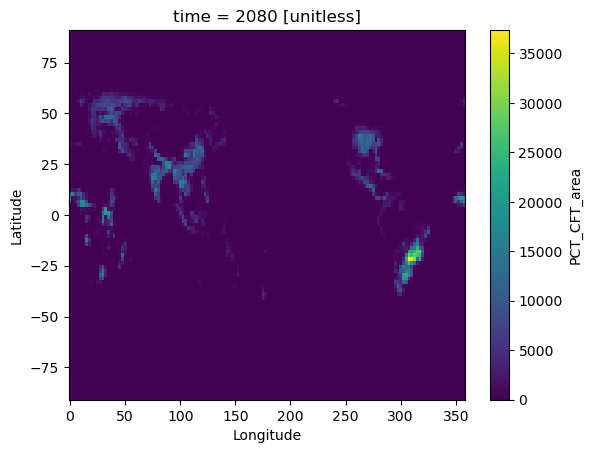

In [11]:
dset1['PCT_CFT_area'].sel(cft=cane).sum('cft').sel(time=2080).plot()

In [30]:
print(((area_2080_corn)-(area_2015_corn)).sum())
print(area_2080_cane_canecase.sum())


<xarray.DataArray 'PCT_CFT_area' ()>
array(0.42282588)
<xarray.DataArray 'PCT_CFT_area' ()>
array(10.52505061)
Coordinates:
    time     int32 2080


## plot the variable PCT_CF_area for all 3 simulations

<xarray.DataArray 'PCT_CFT_area' (Latitude: 96, Longitude: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time       int32 2080
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5


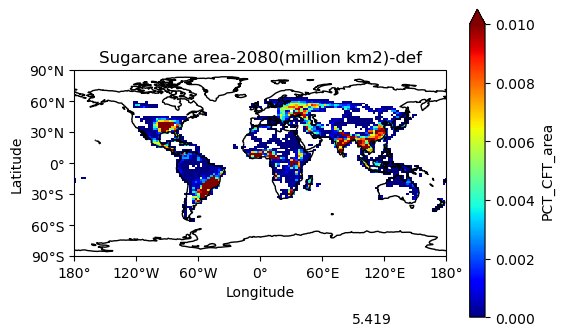

<xarray.DataArray 'PCT_CFT_area' (Latitude: 96, Longitude: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time       int32 2080
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5


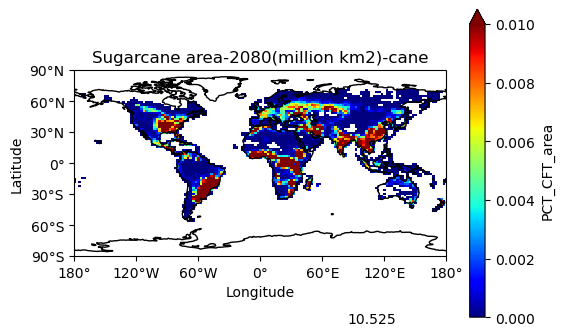

In [18]:
area_2080_tot_canecase
area_2080_cane_canecase
area_2080_corn_canecase

# Create a list of different area_2080_def values
Variables = [area_2080_cane, area_2080_cane_canecase ]  # for the default simulation
#Variables = [area_2080_tot_corncase, area_2080_cane_corncase, area_2080_corn_corncase]  # modified corn
#Variables = [area_2080_tot_canecase, area_2080_cane_canecase, area_2080_corn_canecase]

titles = ['Sugarcane area-2080(million km2)-def', 'Sugarcane area-2080(million km2)-cane'] 
#titles = ['Total Crop area-2080 (million km2)-corncase', 'Sugarcane area-2080 (million km2)-corncase', 'Corn area-2080 (million km2)-corncase']  
#titles = ['Total Crop area-2080(million km2)-canecase', 'Sugarcane area-2080(million km2)-canecase ', 'Corn area-2080(million km2)-canecase '] 

for variable,title in zip(Variables,titles):
    print(variable)
    fig, axs = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = plt.get_cmap('jet',)
    variable.plot(cmap=cmap,vmin=0.00,vmax=0.01)
    
    Annual_sum = variable.sum().item()
    plt.text(0.8, -0.3, f"{Annual_sum:.3f}", fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)
    plt.title(title)
    axs.coastlines(linewidth=1)
    axs.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs.xaxis.set_major_formatter(lon_formatter)
    axs.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs.yaxis.set_major_formatter(lat_formatter)

    # Show or save the plot as needed
    plt.show() 


In [30]:
print(area_2080_tot_cane.sum())

<xarray.DataArray 'PCT_CFT_area' ()>
array(23.19133855)
Coordinates:
    time     int32 2080


In [ ]:
print(area_2015_cane.sum())
print(area_2080_cane.sum())
print(area_2080_cane.sum()-area_2015_cane.sum())
print((area_2080_cane-(area_2015_cane)).sum())

Diff_def_cane=area_2080_cane- (area_2015_cane)
print (Diff_def_cane.sum())

In [23]:
print(area_2015_cane.sum())
print(area_2080_cane_cane.sum())
print((area_2080_cane_cane.sum())- (area_2015_cane.sum()))
Diff_case2_cane=area_2080_cane_cane- (area_2015_cane)
print (Diff_case2_cane.sum())
print(((area_2080_cane_cane)- (area_2015_cane)).sum())

<xarray.DataArray 'PCT_CFT_area' ()>
array(0.25758305)
Coordinates:
    time     int32 2015
<xarray.DataArray 'PCT_CFT_area' ()>
array(10.52505061)
Coordinates:
    time     int32 2080
<xarray.DataArray 'PCT_CFT_area' ()>
array(10.26746756)
<xarray.DataArray 'PCT_CFT_area' ()>
array(6.51759231)
<xarray.DataArray 'PCT_CFT_area' ()>
array(6.51759231)


In [24]:
Diff_case1_cane=area_2080_cane_corn- area_2015_cane
print(area_2015_cane.sum())
print(area_2080_cane_corn.sum())
print((area_2080_cane_corn.sum())- (area_2015_cane.sum()))

print (Diff_case1_cane.sum())
print(((area_2080_cane_corn)- (area_2015_cane)).sum())

<xarray.DataArray 'PCT_CFT_area' ()>
array(0.25758305)
Coordinates:
    time     int32 2015
<xarray.DataArray 'PCT_CFT_area' ()>
array(5.41900846)
Coordinates:
    time     int32 2080
<xarray.DataArray 'PCT_CFT_area' ()>
array(5.16142541)
<xarray.DataArray 'PCT_CFT_area' ()>
array(3.50218835)
<xarray.DataArray 'PCT_CFT_area' ()>
array(3.50218835)


## plot the difference in variable PCT_CF_area for all 3 simulations 

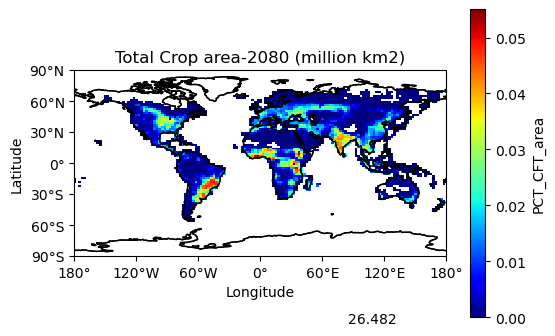

In [12]:
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})

area_2080_def = Totarea_2080_def.where(Totarea_2080_def != 0)

cmap = plt.get_cmap('jet')
#cmap.set_bad(color='white')
area_2080_def.plot(cmap=cmap)

Annual_sum=area_2080_def.sum().item()
plt.text(0.8, -0.3, f"{Annual_sum:.3f}", fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('Total Crop area-2080 (million km2)')
axs.coastlines(linewidth=1)               
axs.coastlines(linewidth=1)
axs.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
axs.xaxis.set_major_formatter(lon_formatter)
axs.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
axs.yaxis.set_major_formatter(lat_formatter) 

  


In [15]:
area_2080_def = Totarea_2080_def.where(Totarea_2080_def != 0)
# Create a list of different area_2080_def values
area_2080_def_list = [area_2080_def]#1, area_2080_def2, area_2080_def3]  # Replace with your actual data

for area_2080_def in area_2080_def_list:
    fig, axs = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = plt.get_cmap('jet')
    area_2080_def.plot(cmap=cmap)

    Annual_sum = area_2080_def.sum().item()
    plt.text(0.8, -0.3, f"{Annual_sum:.3f}", fontsize=10, color='k', ha='center', va='top', transform=plt.gca().transAxes)
    plt.title('Total Crop area-2080 (million km2)')
    axs.coastlines(linewidth=1)
    axs.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs.xaxis.set_major_formatter(lon_formatter)
    axs.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs.yaxis.set_major_formatter(lat_formatter)

    # Show or save the plot as needed
    plt.show() 

"<xarray.DataArray 'PCT_CFT_area' ()>\narray(26.48186221)\nCoordinates:\n    time     int32 2080"

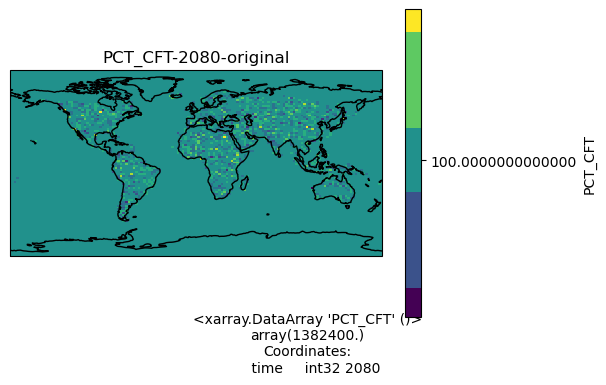

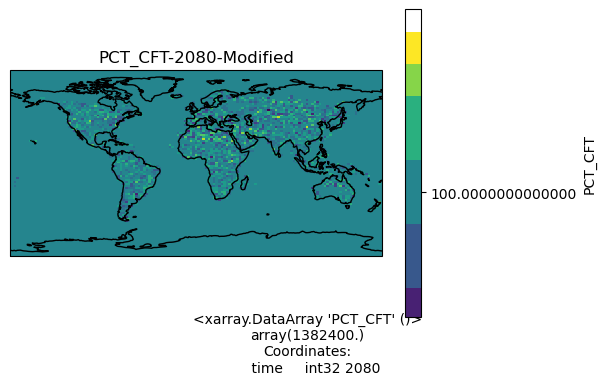

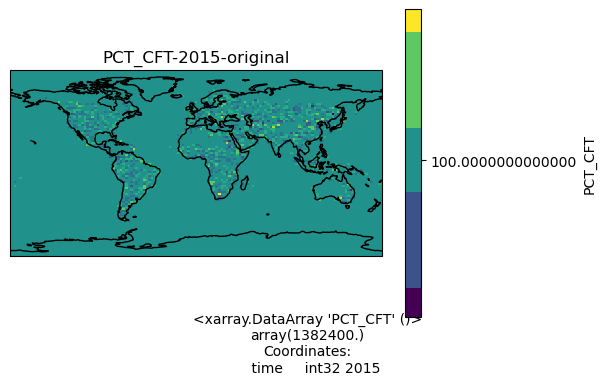

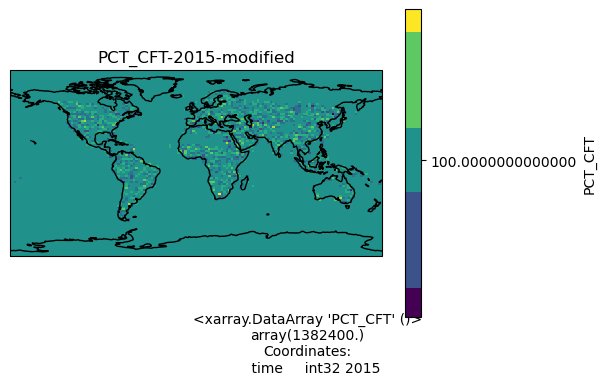

In [3]:

##plot the variable PCT_CFT as it is
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sum('cft').sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT'].sum('cft').sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-original')
axs.coastlines(linewidth=1)    
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset2['PCT_CFT'].sum('cft').sel(time=2080).plot()
plt.text(0.8, -0.3, dset2['PCT_CFT'].sum('cft').sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Modified')
axs.coastlines(linewidth=1)    

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sum('cft').sel(time=2015).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT'].sum('cft').sel(time=2015).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2015-original')
axs.coastlines(linewidth=1)      

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset2['PCT_CFT'].sum('cft').sel(time=2015).plot()
plt.text(0.8, -0.3, dset2['PCT_CFT'].sum('cft').sel(time=2015).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2015-modified')
axs.coastlines(linewidth=1)   


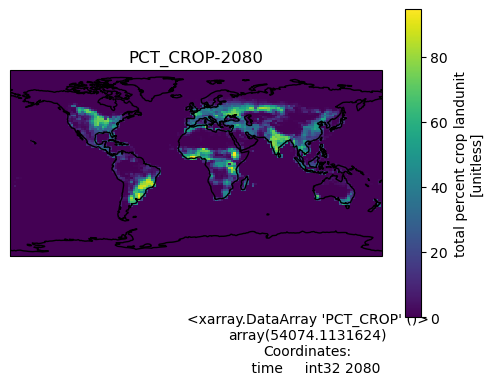

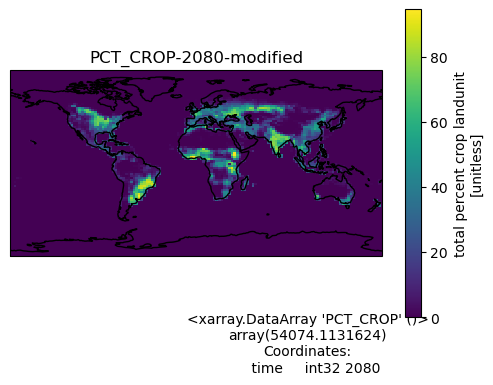

In [3]:
##plot PCT_CROP
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CROP'].sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CROP'].sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CROP-2080')
axs.coastlines(linewidth=1)     

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset2['PCT_CROP'].sel(time=2080).plot()
plt.text(0.8, -0.3, dset2['PCT_CROP'].sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CROP-2080-modified')
axs.coastlines(linewidth=1)  

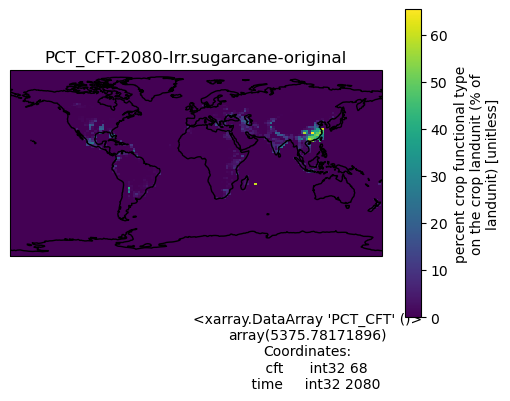

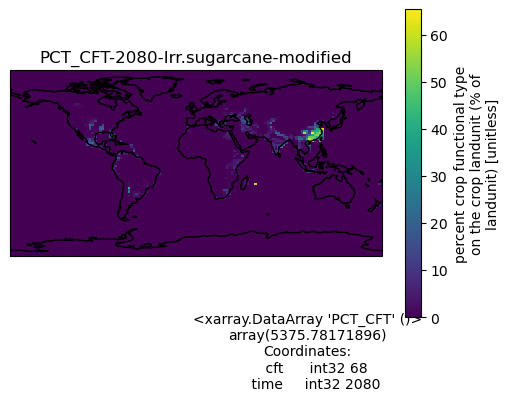

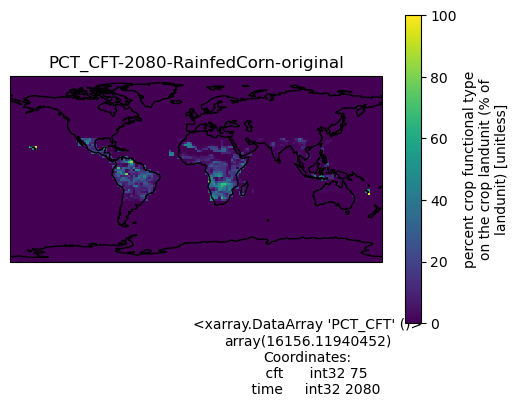

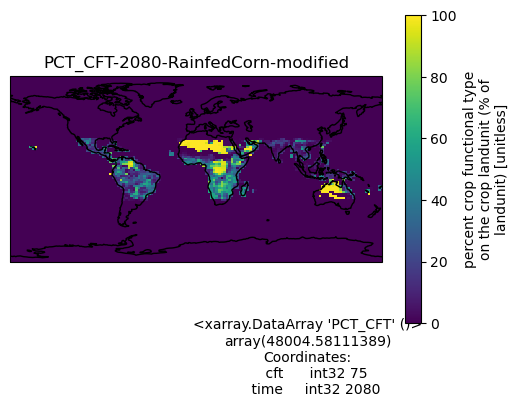

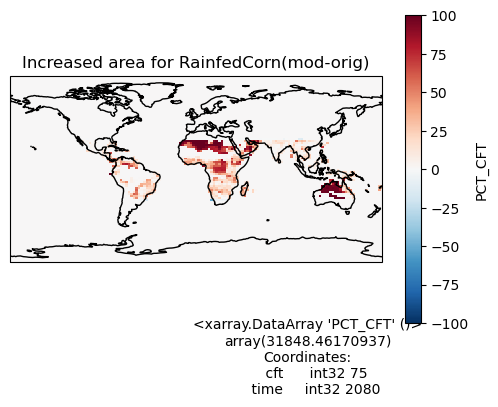

In [5]:
##plot the variable PCT_CFT for sugarcane
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sel(cft=68).sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT'].sel(cft=68).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Irr.sugarcane-original')
axs.coastlines(linewidth=1)     

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset2['PCT_CFT'].sel(cft=68).sel(time=2080).plot()
plt.text(0.8, -0.3, dset2['PCT_CFT'].sel(cft=68).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Irr.sugarcane-modified')
axs.coastlines(linewidth=1)  

##plot the variable PCT_CFT for corn
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sel(cft=75).sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT'].sel(cft=75).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-RainfedCorn-original')
axs.coastlines(linewidth=1)     

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset2['PCT_CFT'].sel(cft=75).sel(time=2080).plot()
plt.text(0.8, -0.3, dset2['PCT_CFT'].sel(cft=75).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-RainfedCorn-modified')
axs.coastlines(linewidth=1) 

a=dset2['PCT_CFT'].sel(cft=75).sel(time=2080)
b=(dset1['PCT_CFT'].sel(cft=75).sel(time=2080))
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
(a- b).plot()
plt.text(0.8, -0.3, (a-b).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('Increased area for RainfedCorn(mod-orig)')
axs.coastlines(linewidth=1)   



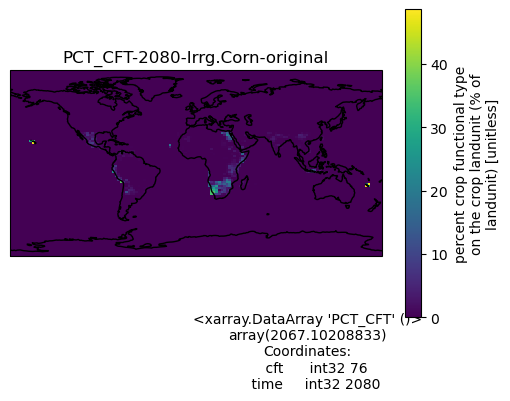

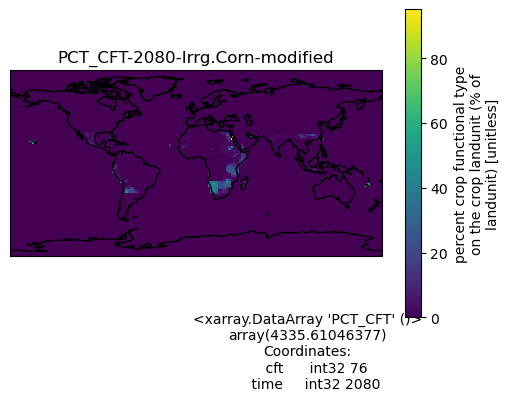

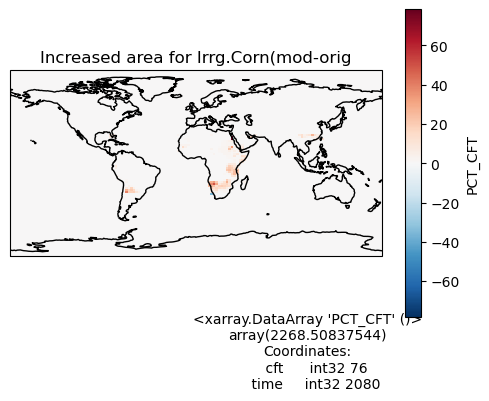

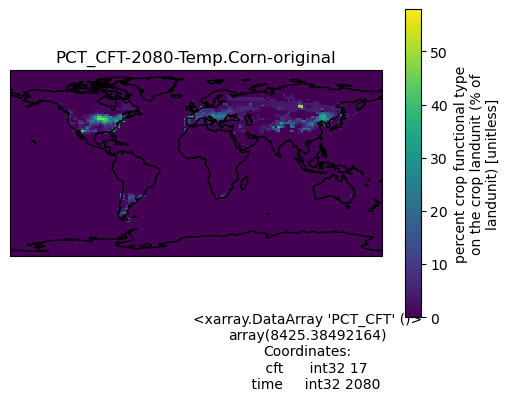

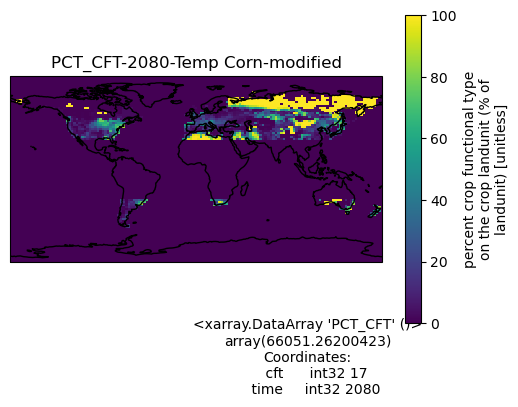

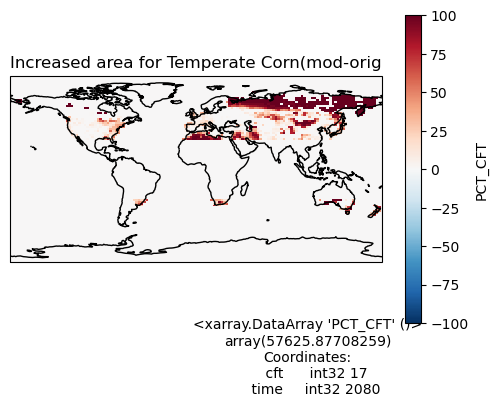

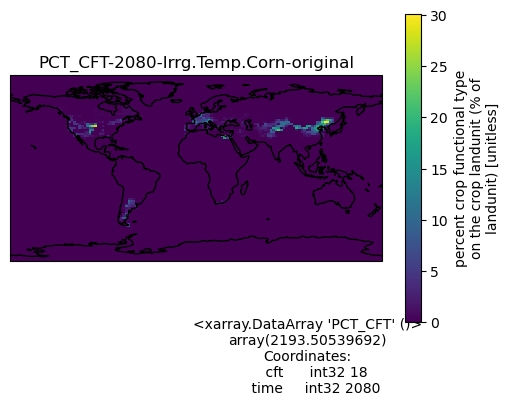

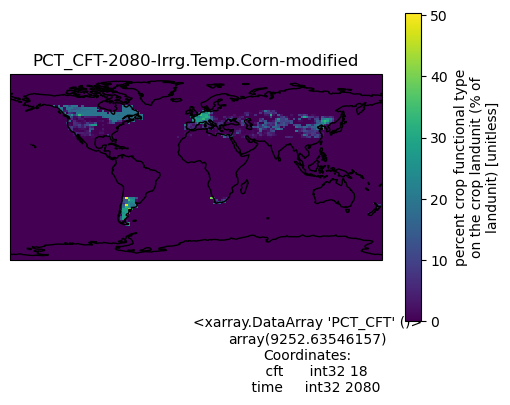

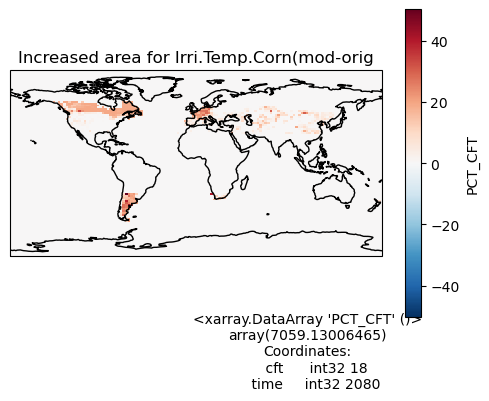

In [6]:

##plot the variable PCT_CFT for Irrg.corn
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sel(cft=76).sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT'].sel(cft=76).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Irrg.Corn-original')
axs.coastlines(linewidth=1)     

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset2['PCT_CFT'].sel(cft=76).sel(time=2080).plot()
plt.text(0.8, -0.3, dset2['PCT_CFT'].sel(cft=76).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Irrg.Corn-modified')
axs.coastlines(linewidth=1) 

a=dset2['PCT_CFT'].sel(cft=76).sel(time=2080)
b=(dset1['PCT_CFT'].sel(cft=76).sel(time=2080))
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
(a- b).plot()
plt.text(0.8, -0.3, (a-b).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('Increased area for Irrg.Corn(mod-orig')
axs.coastlines(linewidth=1)   



##plot the variable PCT_CFT for Irrg.corn
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sel(cft=17).sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT'].sel(cft=17).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Temp.Corn-original')
axs.coastlines(linewidth=1)     

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset2['PCT_CFT'].sel(cft=17).sel(time=2080).plot()
plt.text(0.8, -0.3, dset2['PCT_CFT'].sel(cft=17).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Temp Corn-modified')
axs.coastlines(linewidth=1) 

a=dset2['PCT_CFT'].sel(cft=17).sel(time=2080)
b=(dset1['PCT_CFT'].sel(cft=17).sel(time=2080))
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
(a- b).plot()
plt.text(0.8, -0.3, (a-b).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('Increased area for Temperate Corn(mod-orig')
axs.coastlines(linewidth=1)   
#------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sel(cft=18).sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT'].sel(cft=18).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Irrg.Temp.Corn-original')
axs.coastlines(linewidth=1)     

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset2['PCT_CFT'].sel(cft=18).sel(time=2080).plot()
plt.text(0.8, -0.3, dset2['PCT_CFT'].sel(cft=18).sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-Irrg.Temp.Corn-modified')
axs.coastlines(linewidth=1) 

a=dset2['PCT_CFT'].sel(cft=18).sel(time=2080)
b=(dset1['PCT_CFT'].sel(cft=18).sel(time=2080))
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
(a- b).plot()
plt.text(0.8, -0.3, (a-b).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('Increased area for Irri.Temp.Corn(mod-orig')
axs.coastlines(linewidth=1)   

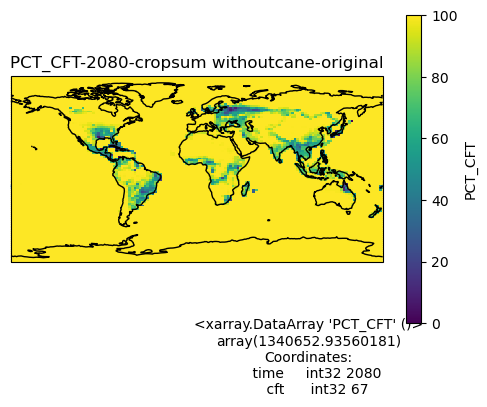

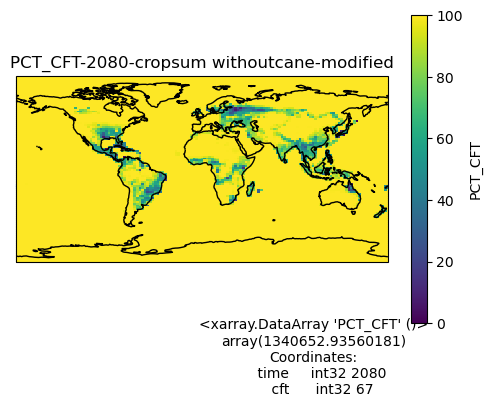

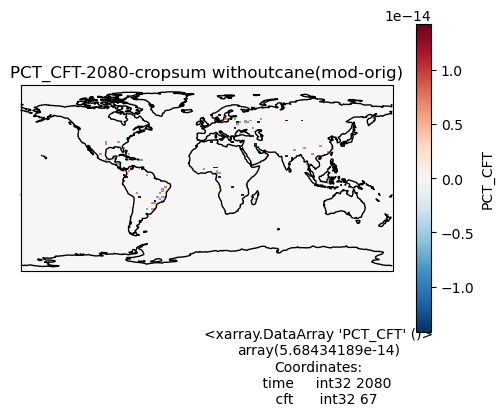

In [38]:

##plot the vSum of crops without sugarcane
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
a=(dset1['PCT_CFT'].sum('cft').sel(time=2080)-(dset1['PCT_CFT'].sel(cft=67).sel(time=2080)))
a.plot()
plt.text(0.8, -0.3, a.sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-cropsum withoutcane-original')
axs.coastlines(linewidth=1)     

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
b=dset1['PCT_CFT'].sum('cft').sel(time=2080)-dset2['PCT_CFT'].sel(cft=67).sel(time=2080)
b.plot()
plt.text(0.8, -0.3, b.sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-cropsum withoutcane-modified')
axs.coastlines(linewidth=1) 


fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
(a- b).plot()
plt.text(0.8, -0.3, (a-b).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT-2080-cropsum withoutcane(mod-orig)')
axs.coastlines(linewidth=1)   

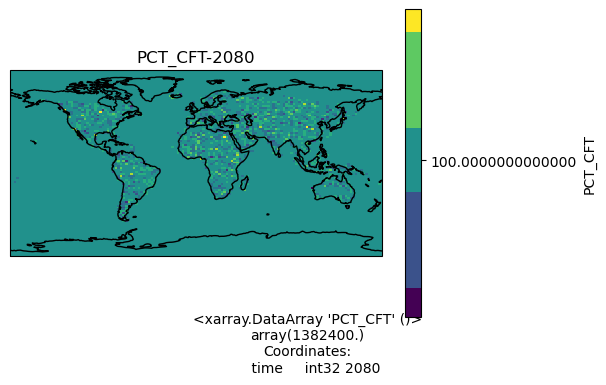

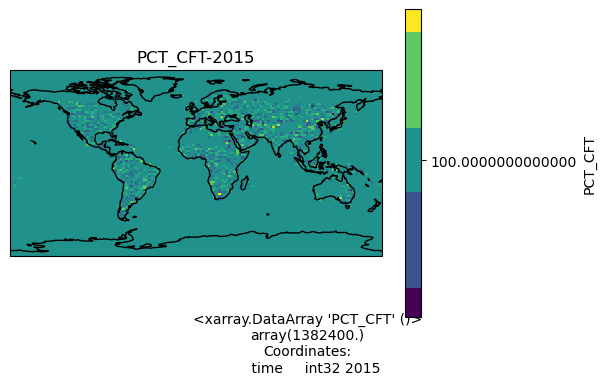

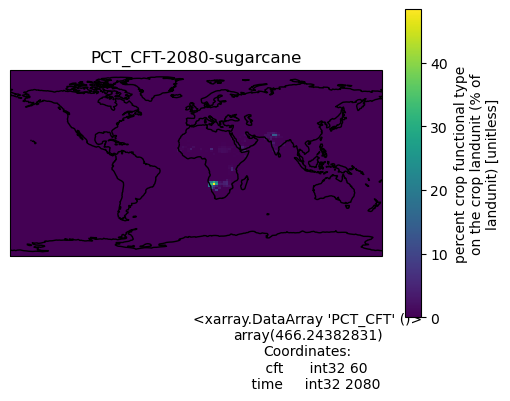

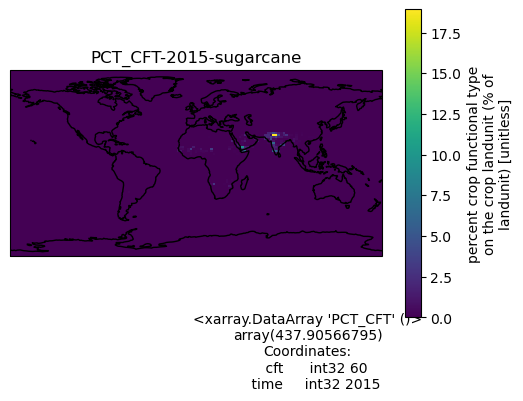

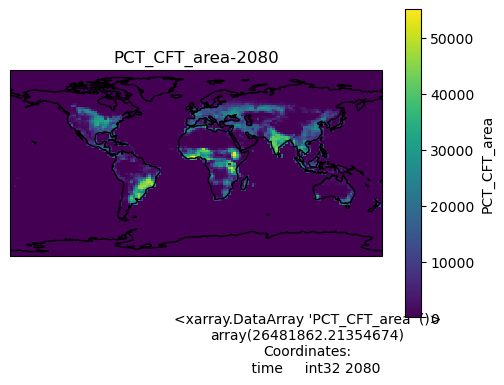

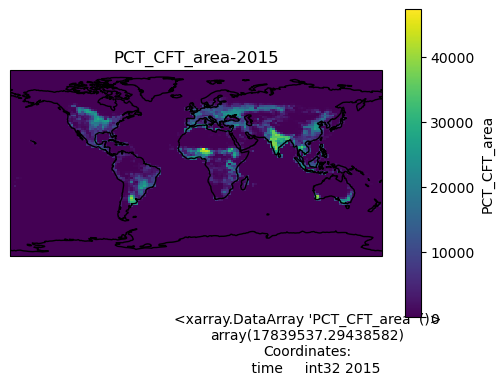

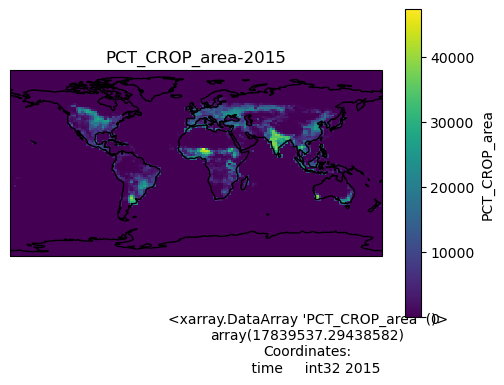

In [6]:


##plot the variable PCT_CFT after converting to area, PCT_CFT_area
dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['AREA']*(dset1['PCT_CROP']/100)   
#dset1['PCT_CFT_area'] = (dset1['PCT_CFT_area'] / 100) * dset1['PCT_CROP_area']        
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_area'].sum('cft').sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT_area'].sum('cft').sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT_area-2080')
axs.coastlines(linewidth=1)

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_area'].sum('cft').sel(time=2015).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT_area'].sum('cft').sel(time=2015).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CFT_area-2015')
axs.coastlines(linewidth=1)

dset1['PCT_CROP_area']=(dset1['PCT_CROP']/100)*dset1['AREA']
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CROP_area'].sel(time=2015).plot()
plt.text(0.8, -0.3, dset1['PCT_CROP_area'].sel(time=2015).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CROP_area-2015')
axs.coastlines(linewidth=1)


##plot the variable PCT_CFT_area after converting it back to percentage
#dset1['PCT_CFT_back'] = dset1['PCT_CFT_area'] / ((dset1['AREA']*(dset1['PCT_CROP'])))*10000
#dset1['PCT_CFT_back'] = dset1['PCT_CFT_area'] / (dset1['AREA'] * dset1['PCT_CROP']) * 100 * 100

#dset1['PCT_CFT_back'].loc[dict(cft=15)].where(dset1['PCT_CFT_back'].loc[dict(cft=15)].isnull(),100)

#dset1['PCT_CFT_back'].where(dset1['PCT_CFT_back'].isnull(), 0)

   # dividing by PCT_CROP which can be zero at all arctic and antarctic region.

# Set dset1['PCT_CFT_back'] to zero where cft > 15 and PCT_CROP is 0.
# dset1['PCT_CFT_back'] = dset1['PCT_CFT_back'].where(((dset1['PCT_CFT'].loc[dict(cft = 16)]) & (dset1['PCT_CROP'] == 0)), 0)



#dset1['PCT_CFT_back'].loc[dict(cft=17)]        #dset1['PCT_CFT_back'].loc[dict(cft=15)]=100 for points where PCT_CROP is zero because 

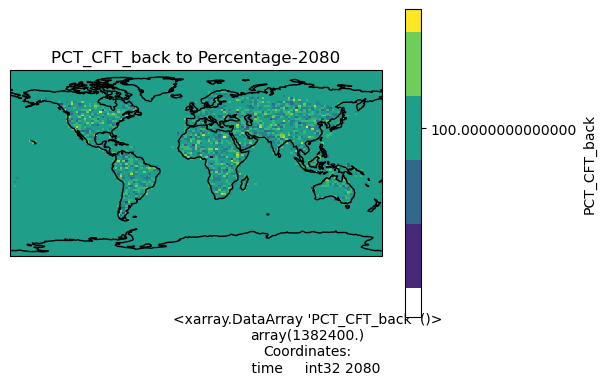

In [13]:
dset1['PCT_CFT_back'] = xr.zeros_like(dset1['PCT_CFT_area'])
dset1['PCT_CFT_back'] = xr.where(dset1['PCT_CROP'] > 0, (dset1['PCT_CFT_area'] / (dset1['AREA'] * (dset1['PCT_CROP'] / 100))) * 100, dset1['PCT_CFT_back'])

# Set 'PCT_CFT_back' to 'PCT_CFT' where 'PCT_CROP' is zero, over ocean over and artic and antarctic regions.
dset1['PCT_CFT_back'] = xr.where(dset1['PCT_CROP'] == 0, dset1['PCT_CFT'], dset1['PCT_CFT_back'])

#dset1['PCT_CFT_back'] = dset1['PCT_CFT_back'].fillna(0)
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft is 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CFT_back'].sum('cft').sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);

plt.title('PCT_CFT_back to Percentage-2080')
axs.coastlines(linewidth=1)



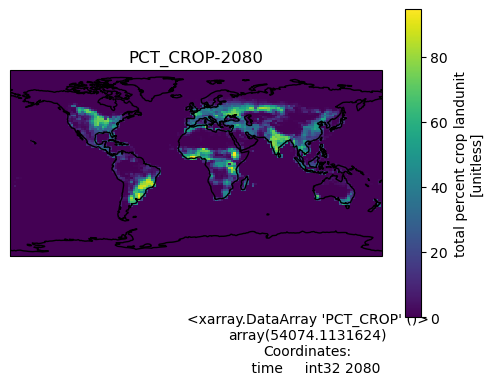

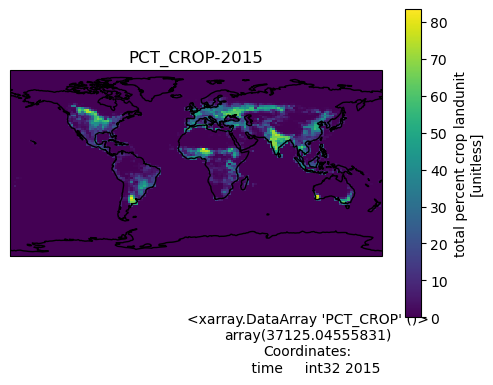

In [4]:
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CROP'].sel(time=2080).plot()
plt.text(0.8, -0.3, dset1['PCT_CROP'].sel(time=2080).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CROP-2080')
axs.coastlines(linewidth=1)         
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CROP'].sel(time=2015).plot()
plt.text(0.8, -0.3, dset1['PCT_CROP'].sel(time=2015).sum(), fontsize=10, color='k', ha='center', va='top',transform=plt.gca().transAxes);
plt.title('PCT_CROP-2015')
axs.coastlines(linewidth=1) 

In [5]:
dset1['PCT_CROP']

<xarray.DataArray 'PCT_CROP' (time: 251, Latitude: 96, Longitude: 144)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * time       (time) int32 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  total percent crop landunit
    units:      unitless

In [55]:
dset1['PCT_CFT_back'].sel(Latitude=-90, Longitude=0,time=2090)
da=dset1['PCT_CFT_back'].sum('cft')
dset1['PCT_CROP'].sel(Latitude=-90, Longitude=0,time=2090)


<xarray.DataArray 'PCT_CROP' ()>
array(0.)
Coordinates:
    time       int32 2090
    Latitude   float64 -90.0
    Longitude  float64 0.0
Attributes:
    long_name:  total percent crop landunit
    units:      unitless

In [48]:
#dset1['PCT_CFT_back'] = xr.where(dset1['PCT_CROP'] == 0,(dset1['PCT_CFT_area'] / (dset1['AREA'])) * 100, (dset1['PCT_CFT_area'] / (dset1['AREA'] * (dset1['PCT_CROP'] / 100))) * 100)

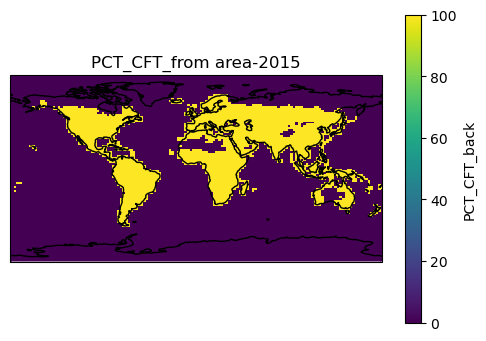

In [44]:
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft is 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)   

ValueError: 'cft' not found in array dimensions ()

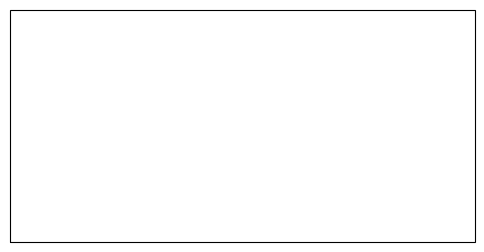

In [47]:

dset1['PCT_CFT_back'] = 100

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft is 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)  
 

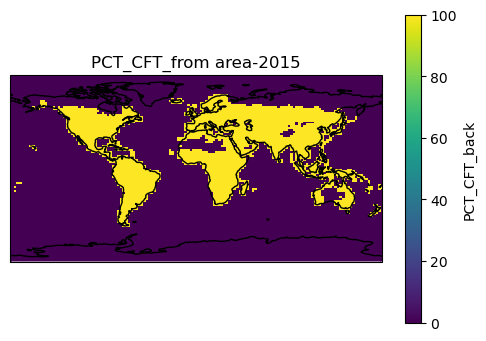

In [4]:
for i in range(15, 79):
    da = dset1['PCT_CFT_back'].sel(cft=i)
    if i == 15:
        da=da.where(dset1['PCT_CROP'] == 0, 100)
    else:
        da= da.where(dset1['PCT_CROP'] == 0, 0)
dset1['PCT_CFT_back'].loc[dict(cft=i)]=da

dset1['PCT_CFT_back'] = (dset1['PCT_CFT_area'] / (dset1['AREA'] * (dset1['PCT_CROP'] / 100))) * 100

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft is 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)


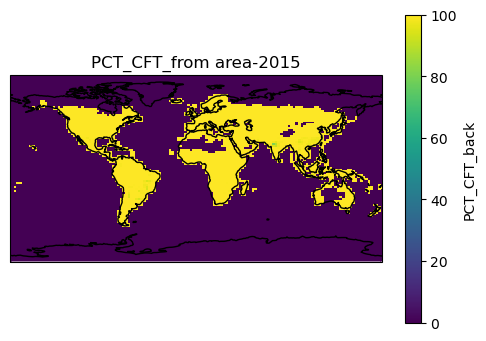

In [8]:
for i in range(15, 79):
    da = dset1['PCT_CFT_area'].sel(cft=i)
    if i == 15:
        da= da.where(dset1['PCT_CROP'] == 0, 100)
    else:
        da= da.where(dset1['PCT_CROP'] == 0, 0)

dset1['PCT_CFT_area'].loc[dict(cft=i)]=da


dset1['PCT_CFT_back'] = (dset1['PCT_CFT_area'] / (dset1['AREA'] * (dset1['PCT_CROP'] / 100))) * 100

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft is 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)

In [52]:
dset1['PCT_CFT_area'].sel(cft=52).sel(time=2015)
dset1['PCT_CFT'].sel(cft=52).sel(time=2015)
dset1['PCT_CFT'].sel(Latitude=-90, Longitude=0,time=2090 )
#dset1['PCT_CFT_area'].sel(cft=52).sel(time=2015)

<xarray.DataArray 'PCT_CFT' (cft: 64)>
array([100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.])
Coordinates:
  * cft        (cft) int32 15 16 17 18 19 20 21 22 ... 71 72 73 74 75 76 77 78
    time       int32 2090
    Latitude   float64 -90.0
    Longitude  float64 0.0
Attributes:
    long_name:  percent crop functional type on the crop landunit (% of landu...
    units:      unitless

In [35]:

#dset1['PCT_CROP']

dset1['PCT_CFT_back'] = (dset1['PCT_CFT_area'] / (dset1['AREA'] * (dset1['PCT_CROP'] / 100))) * 100

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft is 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)

<xarray.DataArray 'PCT_CFT_area' (time: 251, Latitude: 96, Longitude: 144)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
    cft        int32 16
  * time       (time) int32 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5

In [37]:
for i in range(15, 79):
    da = dset1['PCT_CFT_back'].sel(cft=i)
    if i == 15:
        da= da.where(dset1['PCT_CROP'] == 0, 100)
    else:
        da= da.where(dset1['PCT_CROP'] == 0, 0)

dset1['PCT_CFT_back'].loc[dict(cft=i)]=da
print(da)
#dset1['PCT_CFT_back'].sel(cft=15)



<xarray.DataArray 'PCT_CFT_back' (time: 251, Latitude: 96, Longitude: 144)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
       

In [17]:
da['PCT_CFT_back'].sel(cft=15)

KeyError: 'PCT_CFT_back'

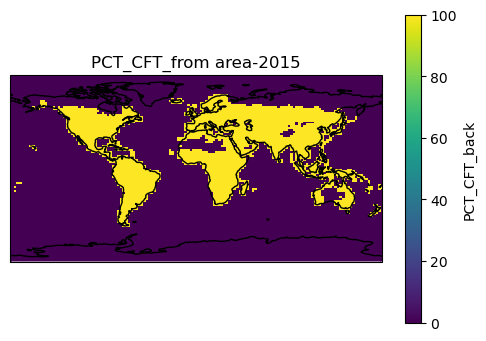

In [6]:
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})  # The value of PCT_CFT over ocean is 100 when cft ios 15 and is zero for all other cfts.
dset1['PCT_CFT_back'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)

In [78]:
dset1['PCT_CFT_back'].loc[dict(cft = 52)].sel(time=2015)
dset1['PCT_CROP'].sel(Latitude=-90, Longitude=0,time=2090)
#dset1['PCT_CROP'].sel(time=2015)
dset1['PCT_CFT_back'] = dset1['PCT_CFT_back'].where(((dset1['PCT_CFT'].loc[dict(cft = 16)])) , 0)
#dset1['PCT_CFT_back'] = xr.where((dset1['PCT_CFT'].loc[dict(cft = 16)]) & (dset1['PCT_CROP'] = 0), 0, dset1['PCT_CFT_back'])
#dset1['PCT_CFT_back'] = xr.where((dset1['PCT_CFT'].loc[dict(cft = 16)]) & (dset1['PCT_CROP'] = 0)), 0, dset1['PCT_CFT_back'])
#dset1['PCT_CFT_back'] = dset1['PCT_CFT_back'].where(((dset1['PCT_CFT'].loc[dict(cft = 16)])) , 0)
#dset1['PCT_CFT_back'] = xr.DataArray(np.where((dset1['PCT_CROP'] == 0) & (dset1['PCT_CFT'].loc[dict(cft = 16)]), 0, dset1['PCT_CFT_back'].loc[dict(cft = 16)]))

In [77]:
dset1['PCT_CFT_back'].sel(Latitude=-90, Longitude=0,time=2090)
dset1['PCT_CROP'].sel(time=2090)>0


<xarray.DataArray 'PCT_CROP' (Latitude: 96, Longitude: 144)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time       int32 2090
  * Latitude   (Latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * Longitude  (Longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5

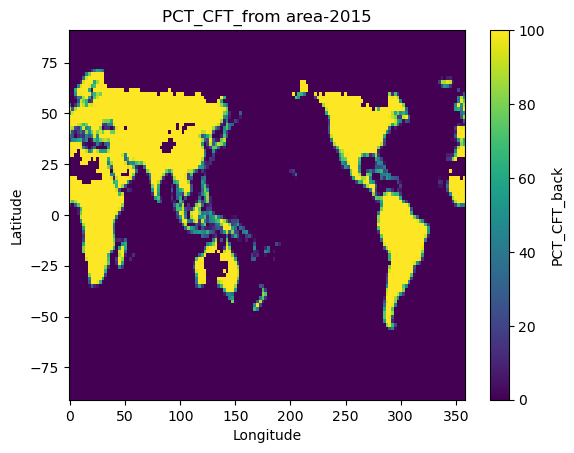

In [10]:
#dset1['PCT_CFT_back'] #= (dset1['PCT_CFT_area'] / (dset1['AREA']*(dset1['PCT_CROP'])/100)) *100
dset1['PCT_CFT_area'].shape
dset1['AREA'].shape
dset1['PCT_CFT_back']=0 .loc[dict(cft=15)]
dset1['PCT_CFT_back'] = (dset1['PCT_CFT_area'] / ((dset1['AREA']*(dset1['PCT_CROP']))))*10000
dset1['PCT_CFT_back'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)


In [27]:
dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['AREA']*(dset1['PCT_CROP']/100)

dset1['PCT_CFT_bk'] = (dset1['PCT_CFT_area']/ (dset1['AREA']*(dset1['PCT_CROP']/100)))*100

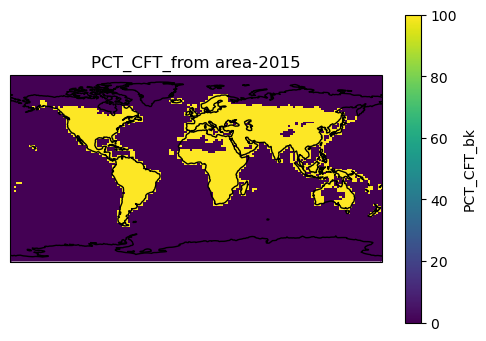

In [28]:

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_bk'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)

(251, 96, 144)
(251, 96, 144)
(251, 96, 144)


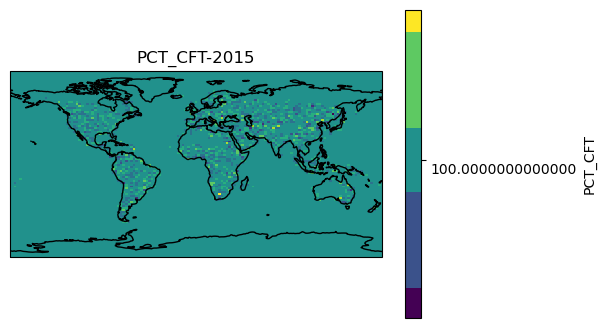

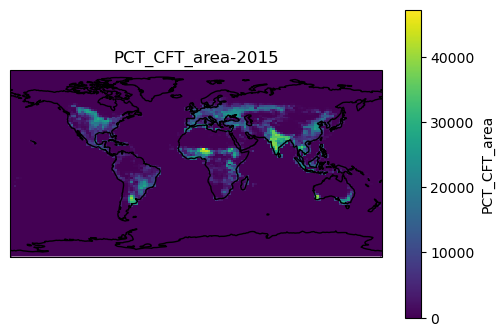

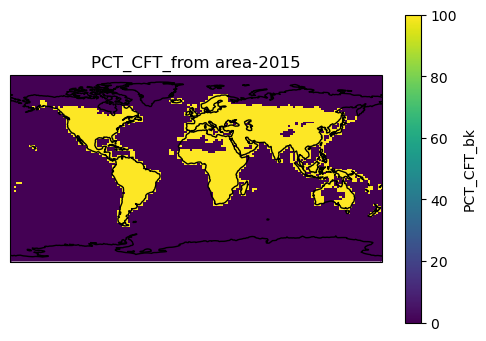

In [34]:
dset1['PCT_CROP_area']=(dset1['PCT_CROP']/100)*dset1['AREA']
dset1['PCT_CROP_bk'] =(dset1['PCT_CROP_area']/dset1['AREA'])*100
#dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['AREA']*(dset1['PCT_CROP']/100)
dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['PCT_CROP_area']
dset1['PCT_CFT_bk']   =(dset1['PCT_CFT_area']/dset1['PCT_CROP_area'])*100

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT-2015')
axs.coastlines(linewidth=1)

fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_area'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_area-2015')
axs.coastlines(linewidth=1)


dset1['PCT_CFT_back'] = dset1['PCT_CFT_area'] / ((dset1['AREA']*(dset1['PCT_CROP'])))*10000
dset1['PCT_CFT_back']
fig, axs = plt.subplots(figsize=(6,4), subplot_kw={'projection': ccrs.PlateCarree()})
dset1['PCT_CFT_bk'].sum('cft').sel(time=2015).plot()
plt.title('PCT_CFT_from area-2015')
axs.coastlines(linewidth=1)
print(dset1['PCT_CFT'].sum('cft').shape)
print(dset1['PCT_CFT_area'].sum('cft').shape)
print(dset1['PCT_CFT_bk'].sum('cft').shape)

#dset1['PCT_CFT_area'] =(dset1['PCT_CFT']/100)*dset1['PCT_CROP_area']